<a href="https://colab.research.google.com/github/ConorD28/Baseball/blob/main/RISP_Research_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Getting Statcast Data**

In [ ]:
!pip install pybaseball
!pip install xlrd

In [2]:
from pybaseball import statcast, statcast_batter
import pandas as pd

In [ ]:
df_23 = statcast(start_dt="2023-07-14", end_dt="2023-10-01")[["game_pk", 'inning', "outs_when_up", "on_1b", "on_2b",
                                                             "on_3b", "balls", "strikes", "batter", "pitcher",
                                                              "events", "des", 'woba_value', 'woba_denom', "estimated_woba_using_speedangle",
                                                            "delta_run_exp", 'bat_speed', 'swing_length', 'launch_speed']] #7/14/23 is first day of bat tracking data

df_24 = statcast(start_dt="2024-03-20", end_dt="2024-09-30")[["game_pk", 'inning', "outs_when_up", "on_1b", "on_2b",
                                                              "on_3b", "balls", "strikes", "batter", "pitcher",
                                                               "events", "des", 'woba_value', 'woba_denom', "estimated_woba_using_speedangle",
                                                             "delta_run_exp", 'bat_speed', 'swing_length', 'launch_speed']]

df_25 = statcast(start_dt="2025-03-18", end_dt="2025-07-07")[["game_pk", 'inning', "outs_when_up", "on_1b", "on_2b",
                                                             "on_3b", "balls", "strikes", "batter", "pitcher",
                                                              "events", "des", 'woba_value', 'woba_denom', "estimated_woba_using_speedangle",
                                                            "delta_run_exp", 'bat_speed', 'swing_length', 'launch_speed']]

In [4]:
df_23.to_csv('2023_Statcast.csv')
df_24.to_csv('2024_Statcast.csv')
df_25.to_csv('2025_Statcast.csv')

# **Split Data**

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
df_23 = pd.read_csv('2023_Statcast.csv')
df_23 = df_23.drop('Unnamed: 0', axis = 1)
df_24 = pd.read_csv('2024_Statcast.csv')
df_24 = df_24.drop('Unnamed: 0', axis = 1)
df_25 = pd.read_csv('2025_Statcast.csv')
df_25 = df_25.drop('Unnamed: 0', axis = 1)

In [7]:
def competitive_swings(df): #Keep only competitive swings and filter out players with < 331 competitive swings:
  #Competitive swing: "The fastest 90% of a player's swings, plus any 60+ MPH swings resulting in an exit velocity of 90+ MPH" (https://baseballsavant.mlb.com/leaderboard/bat-tracking)

  #Drop non swings:
  df = df.dropna(subset=['bat_speed'])
  # Step 1: Compute the 10th percentile of launch_speed per batter
  percentile_10 = df.groupby('batter')['bat_speed'].transform(lambda x: x.quantile(0.10))

  # Step 2: Define two filters
  condition_1 = (df['bat_speed'] >= 60) & (df['launch_speed'] >= 90)
  condition_2 = df['bat_speed'] >= percentile_10

  df = df[condition_1 | condition_2]

  swings = df.groupby('batter')[['bat_speed', 'swing_length']].median()
  swings = swings.rename(columns = {'bat_speed': 'Median_Bat_Speed', 'swing_length': 'Median_Swing_Length'})
  df = pd.merge(df, swings, on = 'batter')

  #filter out players who don't have at least 331 comp swings (330 is not qualified for bat speed on Savant)
  df = df.groupby('batter').filter(lambda x: len(x) >= 331)
  df['Bat_Speed_Diff'] = df['bat_speed'] - df['Median_Bat_Speed']
  df['Swing_Length_Diff'] = df['swing_length'] - df['Median_Swing_Length']
  return df

In [8]:
df_23 = competitive_swings(df_23)
df_24 = competitive_swings(df_24)
df_25 = competitive_swings(df_25)
df = pd.concat([df_23, df_24, df_25])

In [9]:
from scipy.stats import shapiro

def shapiro_test(df, variable):
  # Perform Shapiro-Wilk test
  stat, p_value = shapiro(df[variable])

  # Output results
  print(f"Test Statistic: {stat}")
  print(f"P-Value: {p_value}")

  # Interpret the result
  alpha = 0.05  # significance level
  if p_value > alpha:
      print("Fail to reject the null hypothesis: Data appears to be normally distributed. \n") #If this is true, we will use the mean
  else:
      print("Reject the null hypothesis: Data does not appear to be normally distributed. \n") #If this is true, we will use the median

Judge_competitive_swings = df_24[df_24.batter == 592450]
shapiro_test(Judge_competitive_swings, 'bat_speed')
shapiro_test(Judge_competitive_swings, 'swing_length')

Test Statistic: 0.9940432353022904
P-Value: 0.0005015219526061243
Reject the null hypothesis: Data does not appear to be normally distributed. 

Test Statistic: 0.9936964129578628
P-Value: 0.0003019642733038451
Reject the null hypothesis: Data does not appear to be normally distributed. 



In [11]:
def bar_plot(data_frame, stat, bins, labels, title3):
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)
  group_lengths = data_frame['group'].value_counts().sort_index()
  mean_run_exp = data_frame.groupby('group', observed = False)['delta_run_exp'].mean().reset_index()

  sns.set(style='whitegrid')
  plt.figure(figsize=(8, 5))
  sns.barplot(data=mean_run_exp, x='group', y='delta_run_exp', hue='group')

  plt.title(title3 + ' (Situation)')
  plt.xlabel(stat)
  plt.ylabel('AVG Run Value')
  plt.tight_layout()
  plt.show()

  print('')
  swing_totals = pd.DataFrame({'Swings': group_lengths.values}, index = group_lengths.index.values)
  print(swing_totals)
  print('')

  return mean_run_exp, data_frame

In [12]:
def graph_run_exp(df, stat, speeds2, lengths2, title2): #graph run expectancy change by chosen stat (Bat Speed Diff or Swing Legnth Diff) and add to lists for summary table
  if stat == 'Swing_Length_Diff':
    middle = .1/5
  else:
    middle = .1
  bins = [-float('inf'), middle, .9999, float('inf')]
  labels = [
      '≤ ' + str(middle),
      '> -' + str(middle) + ' to < ' + str(middle),
      '≥ ' + str(middle)]

  mean_run_exp, cut_data_frame = bar_plot(df, stat, bins, labels, title2)
  max_run_exp_row = mean_run_exp.loc[mean_run_exp['delta_run_exp'].idxmax()]
  max_run_exp_group = max_run_exp_row.group

  minimum = df[stat].min()
  maximum = df[stat].max()
  increment_low = (-1*middle - minimum)/4
  increment_high = (maximum - middle)/4

  if max_run_exp_group == '≥ ' + str(middle):
    df = cut_data_frame[cut_data_frame['group'] == '≥ ' + str(middle)]

    minimum = df[stat].describe().iloc[3]
    twenty_fifth_percentile = df[stat].describe().iloc[4]
    fifty_percentile = df[stat].describe().iloc[5]
    seventy_fifth_percentile = df[stat].describe().iloc[6]
    bins = [minimum, twenty_fifth_percentile, fifty_percentile, seventy_fifth_percentile, maximum]

    minimum = str(round(minimum, 1))
    twenty_fifth_percentile = str(round(twenty_fifth_percentile, 1))
    fifty_percentile = str(round(fifty_percentile, 1))
    seventy_fifth_percentile = str(round(seventy_fifth_percentile, 1))
    maximum = str(round(maximum, 1))

    labels = [
      '≥ ' + minimum + ' to ≤ ' + twenty_fifth_percentile,
      '> ' + twenty_fifth_percentile + ' to ≤ ' + fifty_percentile,
      '> ' + fifty_percentile + ' to ≤ ' + seventy_fifth_percentile,
      '> ' + seventy_fifth_percentile + ' to ≤ ' + maximum] #

    bar_plot(df, stat, bins, labels, title2)
    if stat == 'Swing_Length_Diff':
      lengths2.append('Longer')
    else:
      speeds2.append('Faster')

  elif max_run_exp_group == '≤ ' + str(middle):
    df = cut_data_frame[cut_data_frame['group'] == '≤ ' + str(middle)]

    twenty_fifth_percentile = df[stat].describe().iloc[4]
    fifty_percentile = df[stat].describe().iloc[5]
    seventy_fifth_percentile = df[stat].describe().iloc[6]
    maximum = df[stat].describe().iloc[7]
    bins = [minimum, twenty_fifth_percentile, fifty_percentile, seventy_fifth_percentile, maximum]

    minimum = str(round(minimum, 1))
    twenty_fifth_percentile = str(round(twenty_fifth_percentile, 1))
    fifty_percentile = str(round(fifty_percentile, 1))
    seventy_fifth_percentile = str(round(seventy_fifth_percentile, 1))
    maximum = str(round(maximum, 1))

    labels = [
      '≥ ' + minimum + ' to ≤ ' + twenty_fifth_percentile,
      '> ' + twenty_fifth_percentile + ' to ≤ ' + fifty_percentile,
      '> ' + fifty_percentile + ' to ≤ ' + seventy_fifth_percentile,
      '> ' + seventy_fifth_percentile + ' to ≤ ' + maximum] #

    bar_plot(df, stat, bins, labels, title2)
    if stat == 'Swing_Length_Diff':
      lengths2.append('Shorter')
    else:
      speeds2.append('Slower')

  else:
    if stat == 'Swing_Length_Diff':
      lengths2.append('Same')
    else:
      speeds2.append('Same')

  return speeds2, lengths2

In [13]:
RISP = df[df['on_2b'].notna() | df['on_3b'].notna()] #get RISP - runner on 2nd or 3rd

#get different RISP situations:
first_second = RISP[RISP['on_1b'].notna() & RISP['on_2b'].notna() & RISP['on_3b'].isna()]
first_second_2_outs_2_strikes = first_second[(first_second.outs_when_up == 2) & (first_second.strikes == 2)]
first_second_2_outs_under_2_strikes = first_second[(first_second.outs_when_up == 2) & (first_second.strikes < 2)]
first_second_1_out_2_strikes = first_second[(first_second.outs_when_up == 1) & (first_second.strikes == 2)]
first_second_1_out_under_2_strikes = first_second[(first_second.outs_when_up == 1) & (first_second.strikes < 2)]
first_second_0_outs_2_strikes = first_second[(first_second.outs_when_up == 0) & (first_second.strikes == 2)]
first_second_0_outs_under_2_strikes = first_second[(first_second.outs_when_up == 0) & (first_second.strikes < 2)]

first_third = RISP[RISP['on_1b'].notna() & RISP['on_2b'].isna() & RISP['on_3b'].notna()]
first_third_2_outs_2_strikes = first_third[(first_third.outs_when_up == 2) & (first_third.strikes == 2)]
first_third_2_outs_under_2_strikes = first_third[(first_third.outs_when_up == 2) & (first_third.strikes < 2)]
first_third_1_out_2_strikes = first_third[(first_third.outs_when_up == 1) & (first_third.strikes == 2)]
first_third_1_out_under_2_strikes = first_third[(first_third.outs_when_up == 1) & (first_third.strikes < 2)]
first_third_0_outs_2_strikes = first_third[(first_third.outs_when_up == 0) & (first_third.strikes == 2)]
first_third_0_outs_under_2_strikes = first_third[(first_third.outs_when_up == 0) & (first_third.strikes < 2)]

bases_loaded = RISP[RISP['on_1b'].notna() & RISP['on_2b'].notna() & RISP['on_3b'].notna()]
bases_loaded_2_outs_2_strikes = bases_loaded[(bases_loaded.outs_when_up == 2) & (bases_loaded.strikes == 2)]
bases_loaded_2_outs_under_2_strikes = bases_loaded[(bases_loaded.outs_when_up == 2) & (bases_loaded.strikes < 2)]
bases_loaded_1_out_2_strikes = bases_loaded[(bases_loaded.outs_when_up == 1) & (bases_loaded.strikes == 2)]
bases_loaded_1_out_under_2_strikes = bases_loaded[(bases_loaded.outs_when_up == 1) & (bases_loaded.strikes < 2)]
bases_loaded_0_outs_2_strikes = bases_loaded[(bases_loaded.outs_when_up == 0) & (bases_loaded.strikes == 2)]
bases_loaded_0_outs_under_2_strikes = bases_loaded[(bases_loaded.outs_when_up == 0) & (bases_loaded.strikes < 2)]

second = RISP[RISP['on_1b'].isna() & RISP['on_2b'].notna() & RISP['on_3b'].isna()]
second_2_outs_2_strikes = second[(second.outs_when_up == 2) & (second.strikes == 2)]
second_2_outs_under_2_strikes = second[(second.outs_when_up == 2) & (second.strikes < 2)]
second_1_out_2_strikes = second[(second.outs_when_up == 1) & (second.strikes == 2)]
second_1_out_under_2_strikes = second[(second.outs_when_up == 1) & (second.strikes < 2)]
second_0_outs_2_strikes = second[(second.outs_when_up == 0) & (second.strikes == 2)]
second_0_outs_under_2_strikes = second[(second.outs_when_up == 0) & (second.strikes < 2)]

second_third = RISP[RISP['on_1b'].isna() & RISP['on_2b'].notna() & RISP['on_3b'].notna()]
second_third_2_outs_2_strikes = second_third[(second_third.outs_when_up == 2) & (second_third.strikes == 2)]
second_third_2_outs_under_2_strikes = second_third[(second_third.outs_when_up == 2) & (second_third.strikes < 2)]
second_third_1_out_2_strikes = second_third[(second_third.outs_when_up == 1) & (second_third.strikes == 2)]
second_third_1_out_under_2_strikes = second_third[(second_third.outs_when_up == 1) & (second_third.strikes < 2)]
second_third_0_outs_2_strikes = second_third[(second_third.outs_when_up == 0) & (second_third.strikes == 2)]
second_third_0_outs_less_2_strikes = second_third[(second_third.outs_when_up == 0) & (second_third.strikes < 2)]

third = RISP[RISP['on_1b'].isna() & RISP['on_2b'].isna() & RISP['on_3b'].notna()]
third_2_outs_2_strikes = third[(third.outs_when_up == 2) & (third.strikes == 2)]
third_2_outs_under_2_strikes = third[(third.outs_when_up == 2) & (third.strikes < 2)]
third_1_out_2_strikes = third[(third.outs_when_up == 1) & (third.strikes == 2)]
third_1_out_under_2_strikes = third[(third.outs_when_up == 1) & (third.strikes < 2)]
third_0_outs_2_strikes = third[(third.outs_when_up == 0) & (third.strikes == 2)]
third_0_outs_under_2_strikes = third[(third.outs_when_up == 0) & (third.strikes < 2)]

In [18]:
second_third_24 = df_24[df_24['on_1b'].isna() & df_24['on_2b'].notna() & df_24['on_3b'].notna()]
second_third_hr_24 = second_third[(second_third.events == 'home_run') & (second_third.strikes	== 2) & (second_third.outs_when_up == 1)]
second_third_hr_24.head()
#inning does not affect delta_run_exp, but count does as seen below.

,game_pk,inning,outs_when_up,on_1b,on_2b,on_3b,balls,strikes,batter,pitcher,...,estimated_woba_using_speedangle,delta_run_exp,bat_speed,swing_length,launch_speed,Median_Bat_Speed,Median_Swing_Length,Bat_Speed_Diff,Swing_Length_Diff,Unnamed: 0
4764,716388,4,1,NaN,670770.0,663697.0,3,2,687952,596271,...,1.488,1.042,70.9,6.8,105.4,73.4,7.3,-2.5,-0.5,NaN
26025,716557,5,1,NaN,679032.0,669016.0,2,2,656941,571945,...,1.690,1.109,80.0,7.7,114.1,77.4,7.9,2.6,-0.2,NaN
44424,716708,7,1,NaN,663611.0,543228.0,1,2,666624,592426,...,2.000,1.117,79.0,8.0,108.3,75.5,8.0,3.5,0.0,NaN
60565,716847,7,1,NaN,547180.0,607208.0,2,2,592206,606149,...,0.692,1.109,72.6,8.1,99.9,72.5,7.7,0.1,0.4,NaN
80961,716994,1,1,NaN,677951.0,672580.0,2,2,521692,669302,...,1.797,1.109,72.4,8.2,104.9,72.9,8.0,-0.5,0.2,NaN


Run Value = delta_run_exp = (run_exp after pitch) - (run_exp before pitch) + (runs scored on the pitch)

# **Table/Graphs of 2 Strike RISP Splits**

In [19]:
list2 = [first_second_2_outs_2_strikes, first_second_1_out_2_strikes, first_second_0_outs_2_strikes,
         first_third_2_outs_2_strikes, first_third_1_out_2_strikes, first_third_0_outs_2_strikes,
         bases_loaded_2_outs_2_strikes, bases_loaded_1_out_2_strikes, bases_loaded_0_outs_2_strikes,
         second_2_outs_2_strikes, second_1_out_2_strikes, second_0_outs_2_strikes,
         second_third_2_outs_2_strikes, second_third_1_out_2_strikes, second_third_0_outs_2_strikes,
         third_2_outs_2_strikes, third_1_out_2_strikes, third_0_outs_2_strikes]
titles = ['first_second_2_outs_2_strikes', 'first_second_1_out_2_strikes', 'first_second_0_outs_2_strikes',
         'first_third_2_outs_2_strikes', 'first_third_1_out_2_strikes', 'first_third_0_outs_2_strikes',
         'bases_loaded_2_outs_2_strikes', 'bases_loaded_1_out_2_strikes', 'bases_loaded_0_outs_2_strikes',
         'second_2_outs_2_strikes', 'second_1_out_2_strikes', 'second_0_outs_2_strikes',
         'second_third_2_outs_2_strikes', 'second_third_1_out_2_strikes', 'second_third_0_outs_2_strikes',
         'third_2_outs_2_strikes', 'third_1_out_2_strikes', 'third_0_outs_2_strikes']

/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


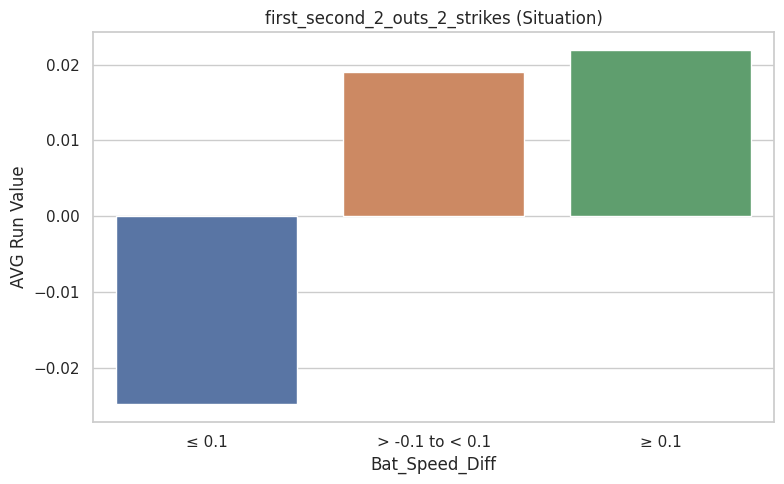


                 Swings
≤ 0.1              2869
> -0.1 to < 0.1     349
≥ 0.1              1320



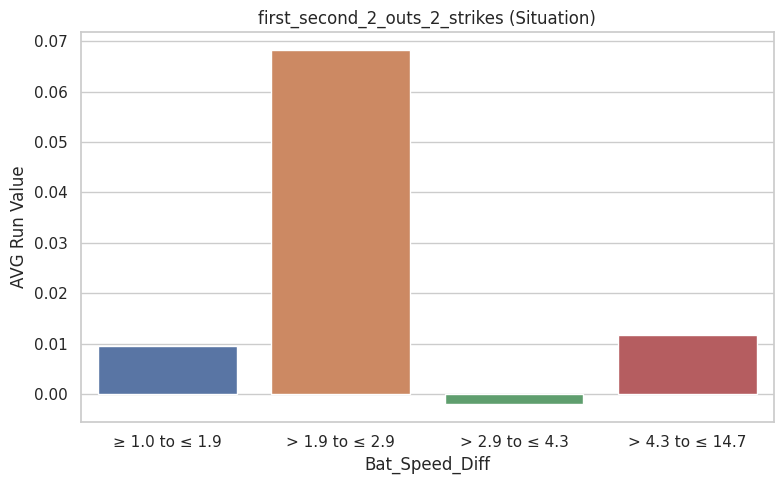


                 Swings
≥ 1.0 to ≤ 1.9      313
> 1.9 to ≤ 2.9      334
> 2.9 to ≤ 4.3      328
> 4.3 to ≤ 14.7     320



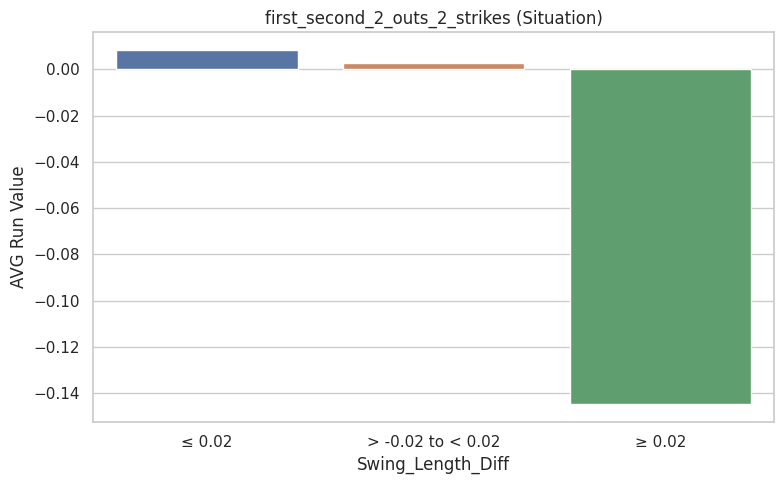


                   Swings
≤ 0.02               2479
> -0.02 to < 0.02    1634
≥ 0.02                417



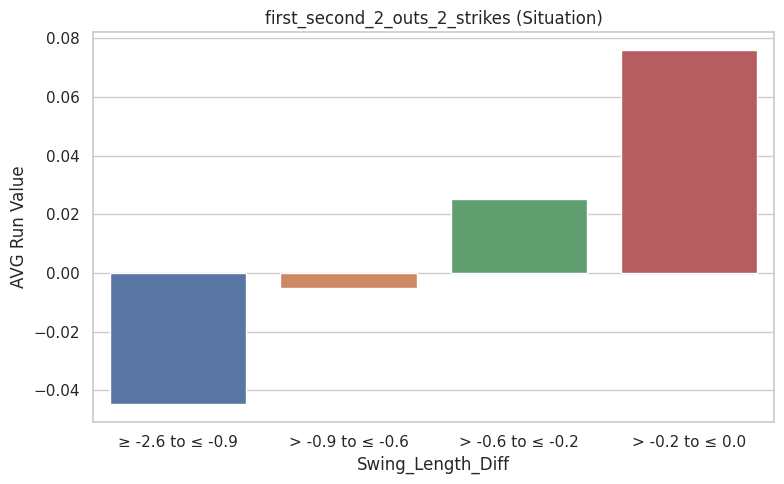


                  Swings
≥ -2.6 to ≤ -0.9     692
> -0.9 to ≤ -0.6     556
> -0.6 to ≤ -0.2     754
> -0.2 to ≤ 0.0      475



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


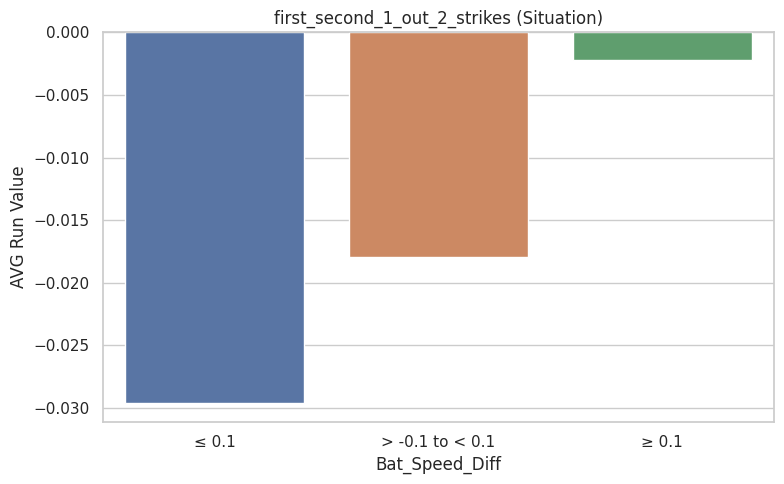


                 Swings
≤ 0.1              2306
> -0.1 to < 0.1     290
≥ 0.1              1138



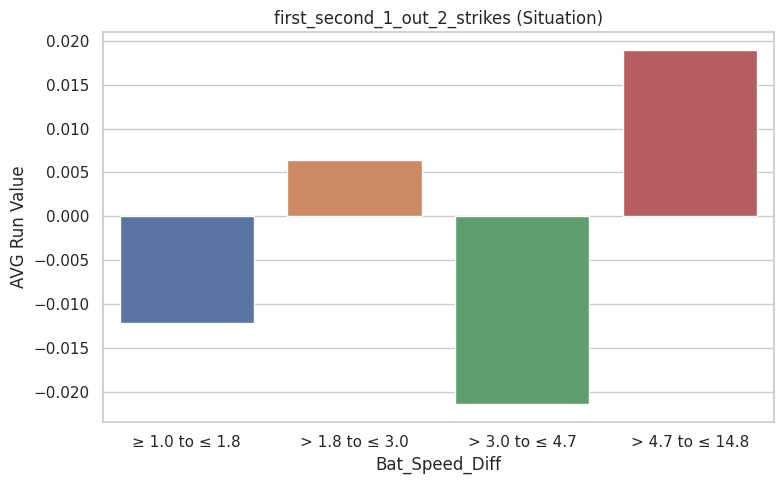


                 Swings
≥ 1.0 to ≤ 1.8      284
> 1.8 to ≤ 3.0      305
> 3.0 to ≤ 4.7      276
> 4.7 to ≤ 14.8     272



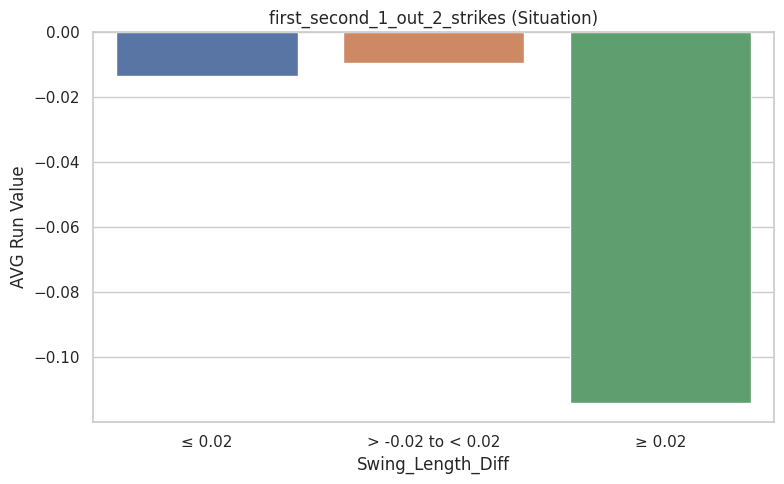


                   Swings
≤ 0.02               2055
> -0.02 to < 0.02    1358
≥ 0.02                316



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


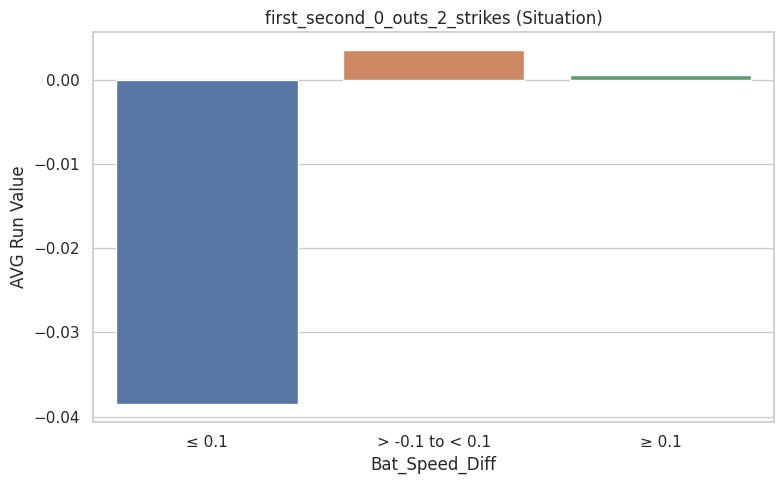


                 Swings
≤ 0.1              1280
> -0.1 to < 0.1     156
≥ 0.1               626



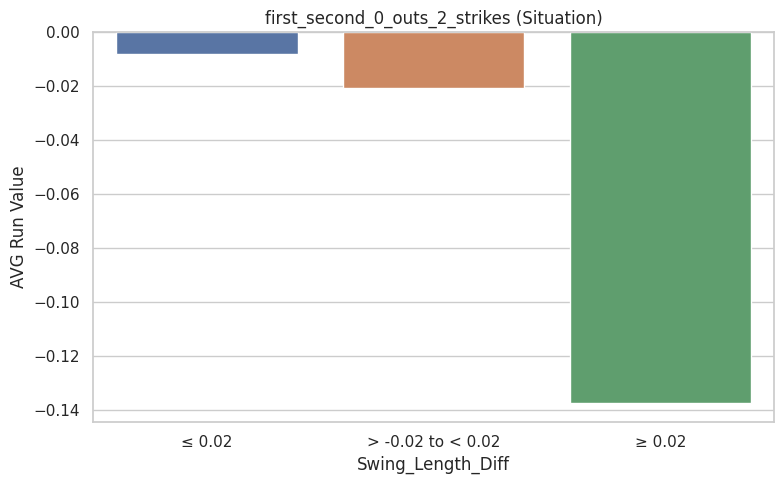


                   Swings
≤ 0.02               1152
> -0.02 to < 0.02     735
≥ 0.02                175



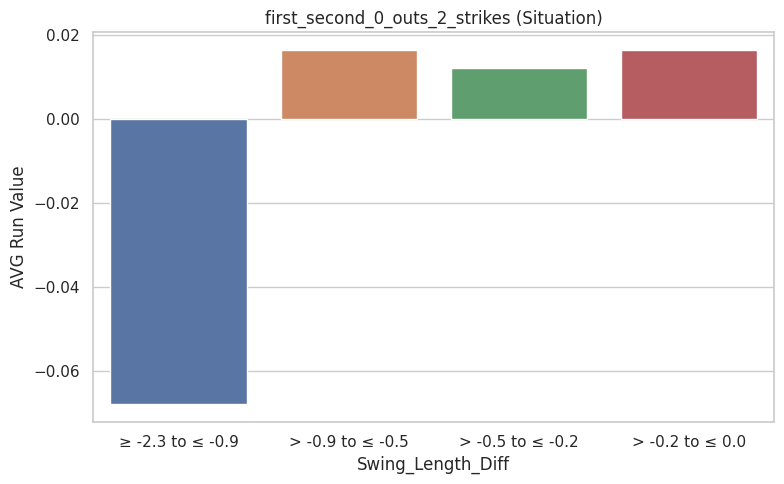


                  Swings
≥ -2.3 to ≤ -0.9     310
> -0.9 to ≤ -0.5     265
> -0.5 to ≤ -0.2     347
> -0.2 to ≤ 0.0      228



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


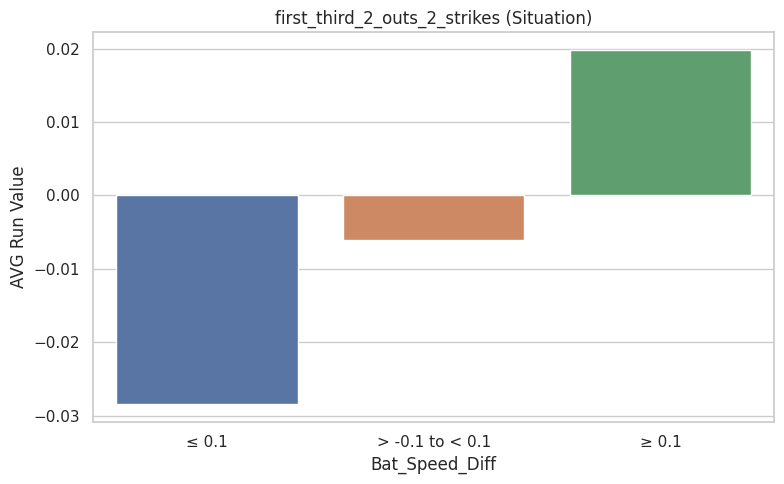


                 Swings
≤ 0.1              1130
> -0.1 to < 0.1     135
≥ 0.1               551



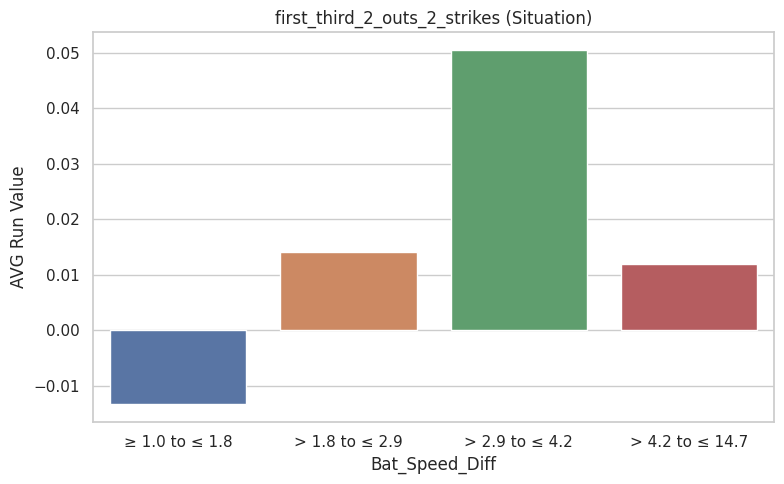


                 Swings
≥ 1.0 to ≤ 1.8      128
> 1.8 to ≤ 2.9      130
> 2.9 to ≤ 4.2      137
> 4.2 to ≤ 14.7     138



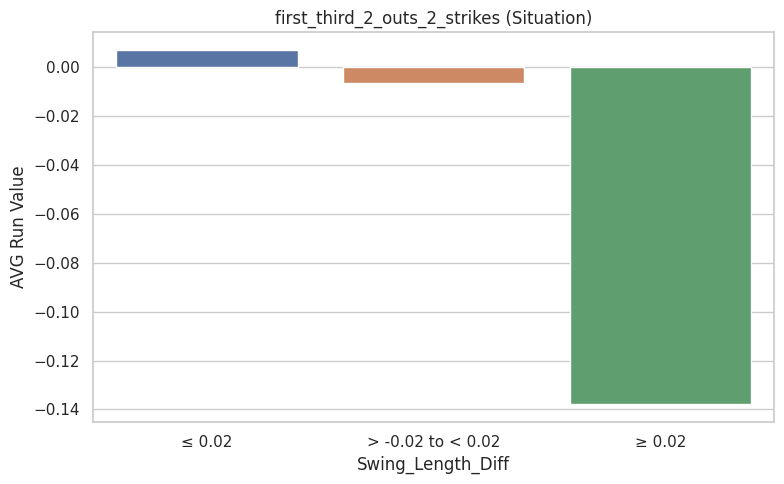


                   Swings
≤ 0.02                988
> -0.02 to < 0.02     646
≥ 0.02                180



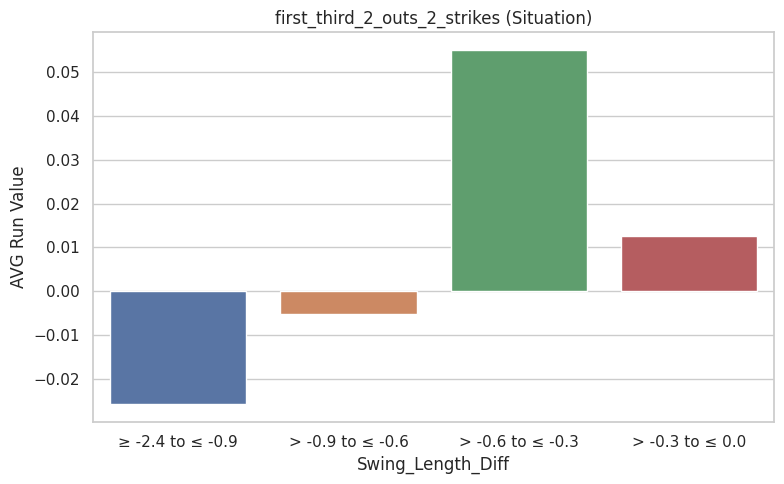


                  Swings
≥ -2.4 to ≤ -0.9     277
> -0.9 to ≤ -0.6     240
> -0.6 to ≤ -0.3     226
> -0.3 to ≤ 0.0      244



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


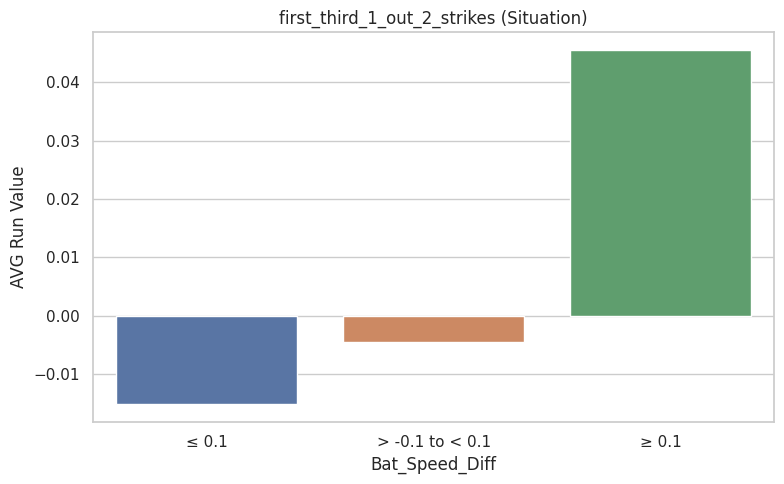


                 Swings
≤ 0.1               942
> -0.1 to < 0.1     108
≥ 0.1               400



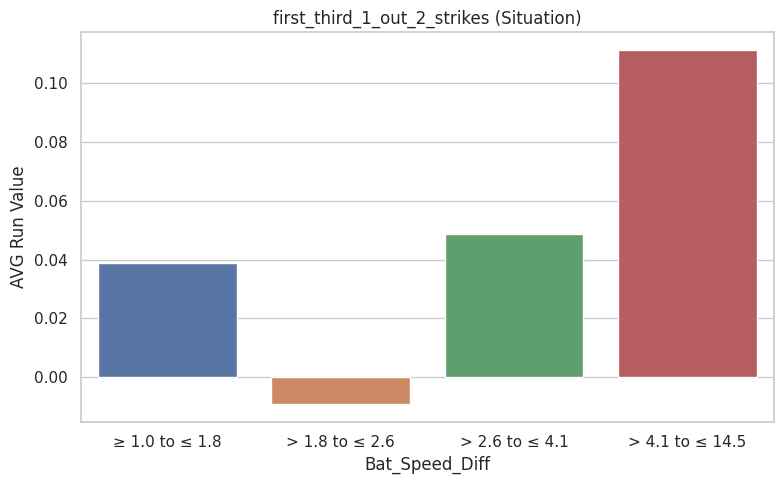


                 Swings
≥ 1.0 to ≤ 1.8       89
> 1.8 to ≤ 2.6      104
> 2.6 to ≤ 4.1       96
> 4.1 to ≤ 14.5     100



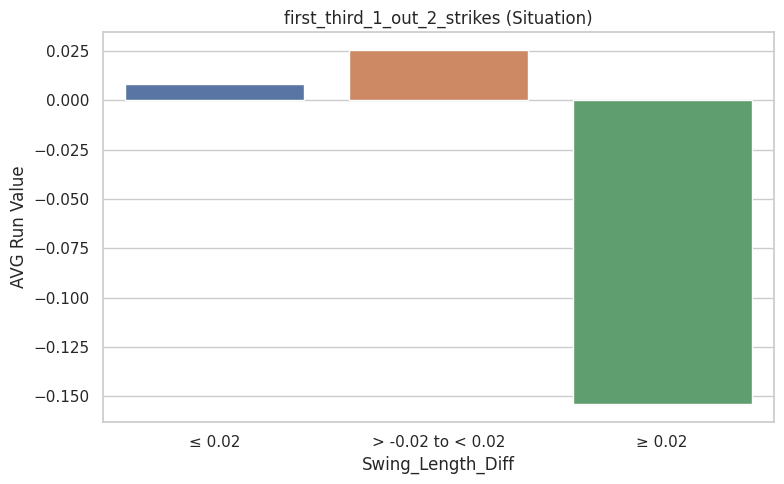


                   Swings
≤ 0.02                841
> -0.02 to < 0.02     503
≥ 0.02                105



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


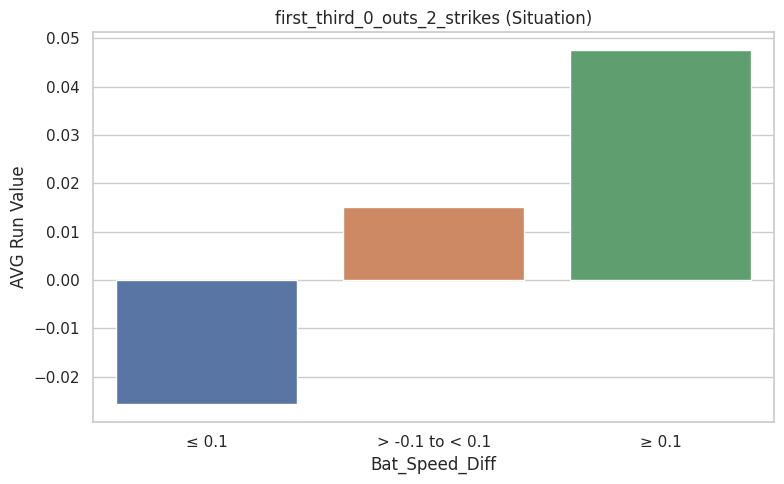


                 Swings
≤ 0.1               491
> -0.1 to < 0.1      48
≥ 0.1               203



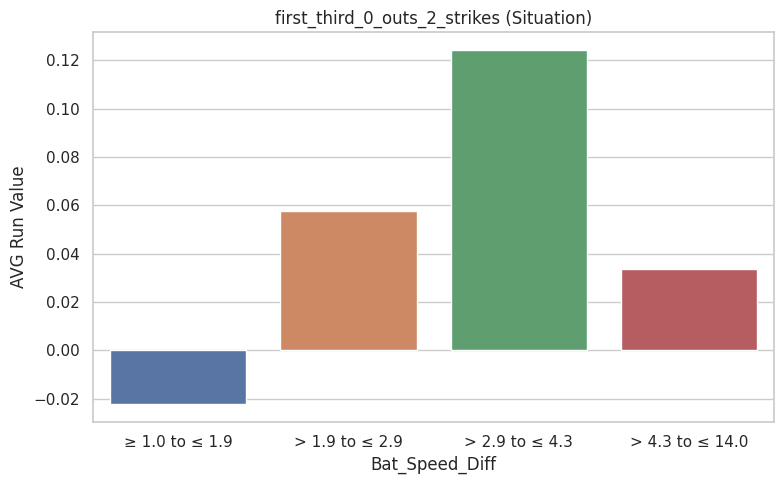


                 Swings
≥ 1.0 to ≤ 1.9       47
> 1.9 to ≤ 2.9       50
> 2.9 to ≤ 4.3       49
> 4.3 to ≤ 14.0      51



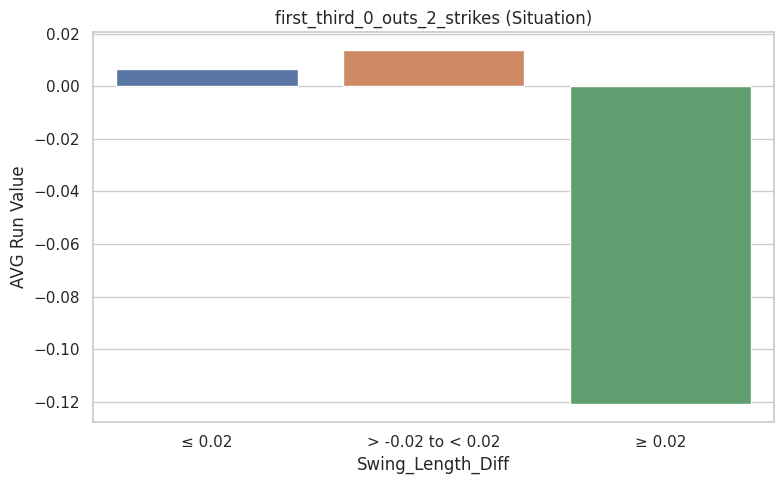


                   Swings
≤ 0.02                395
> -0.02 to < 0.02     277
≥ 0.02                 69



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


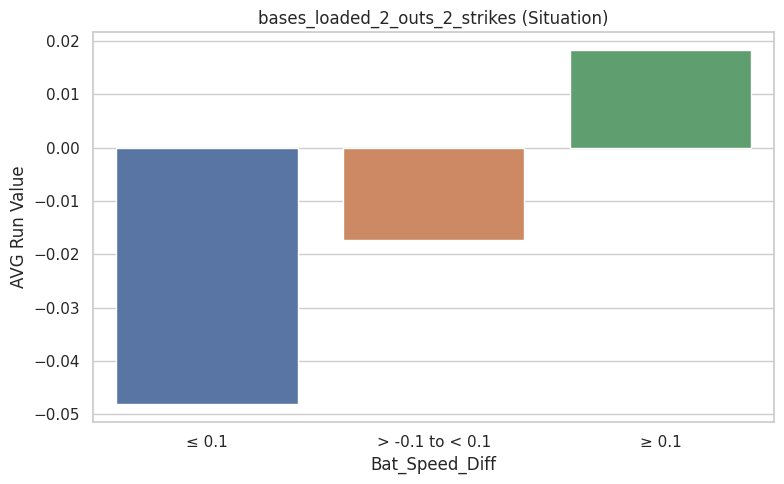


                 Swings
≤ 0.1              1020
> -0.1 to < 0.1     129
≥ 0.1               529



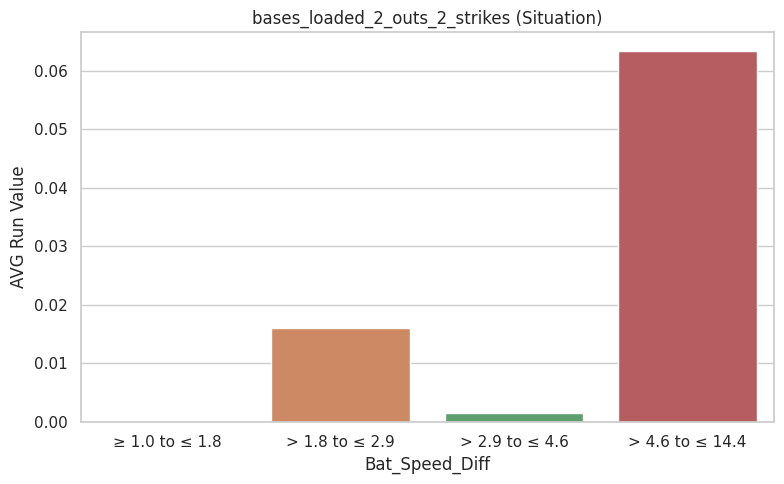


                 Swings
≥ 1.0 to ≤ 1.8      119
> 1.8 to ≤ 2.9      131
> 2.9 to ≤ 4.6      137
> 4.6 to ≤ 14.4     127



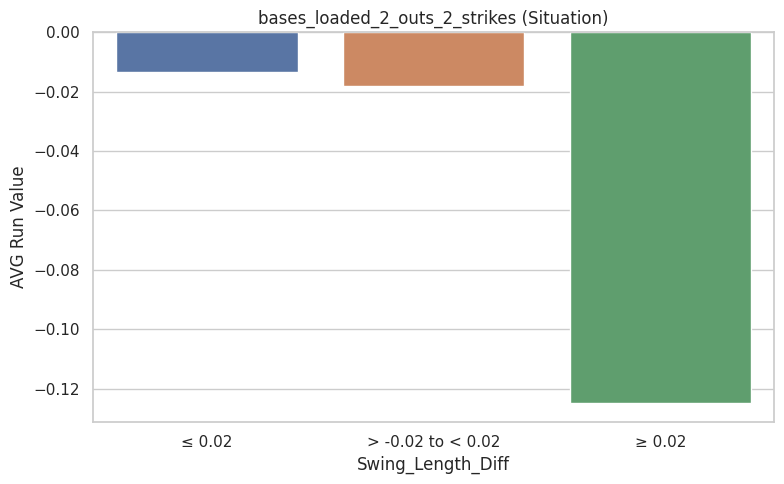


                   Swings
≤ 0.02                921
> -0.02 to < 0.02     612
≥ 0.02                145



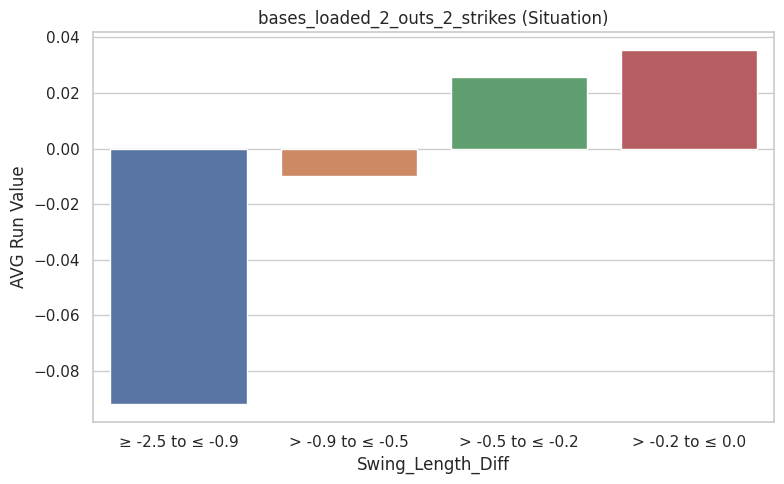


                  Swings
≥ -2.5 to ≤ -0.9     243
> -0.9 to ≤ -0.5     254
> -0.5 to ≤ -0.2     230
> -0.2 to ≤ 0.0      193



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


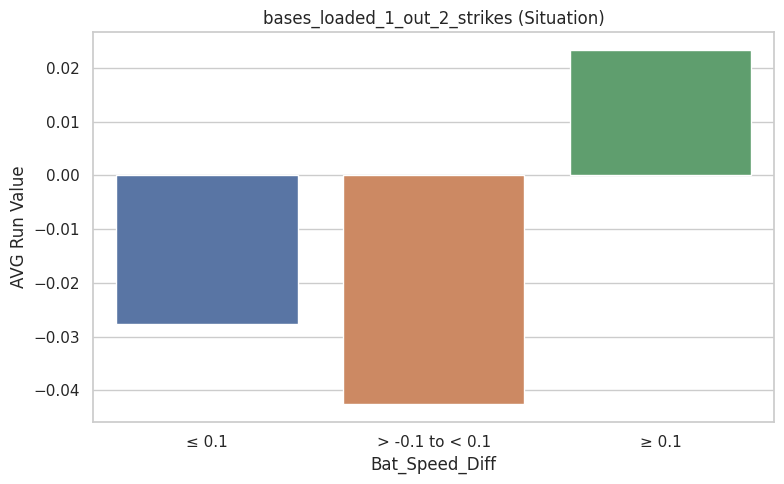


                 Swings
≤ 0.1               815
> -0.1 to < 0.1     118
≥ 0.1               360



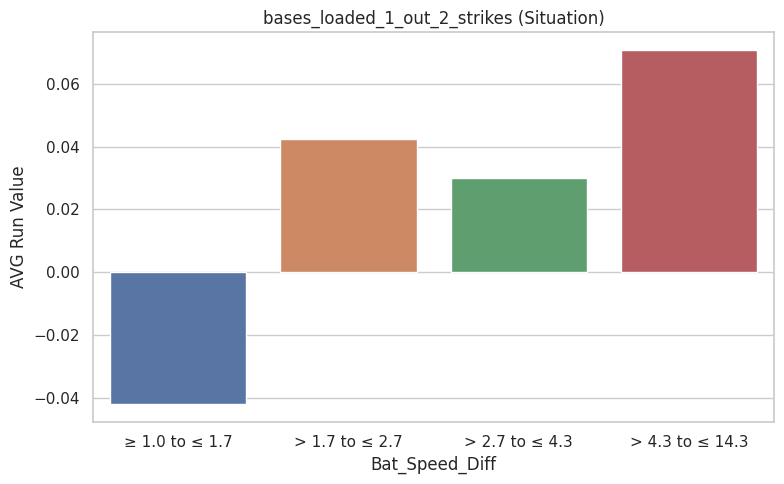


                 Swings
≥ 1.0 to ≤ 1.7       94
> 1.7 to ≤ 2.7       86
> 2.7 to ≤ 4.3       93
> 4.3 to ≤ 14.3      86



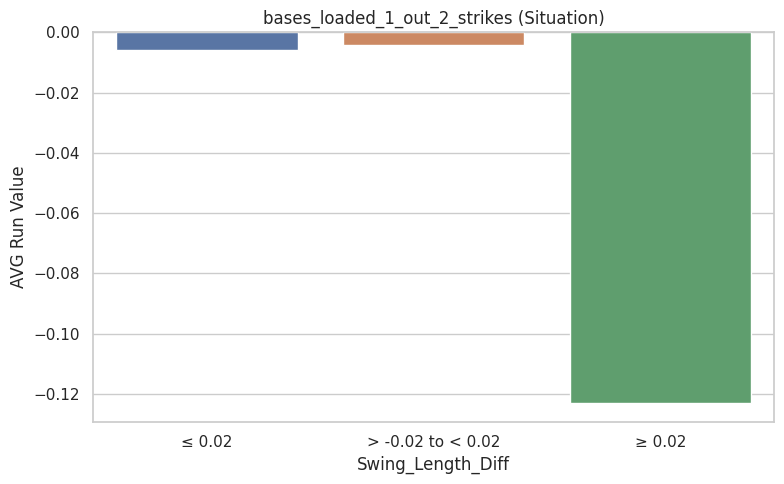


                   Swings
≤ 0.02                724
> -0.02 to < 0.02     461
≥ 0.02                105



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


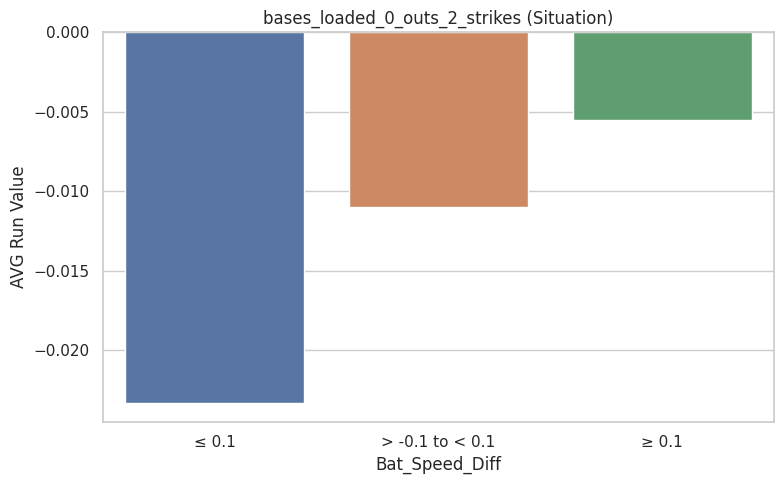


                 Swings
≤ 0.1               351
> -0.1 to < 0.1      48
≥ 0.1               148



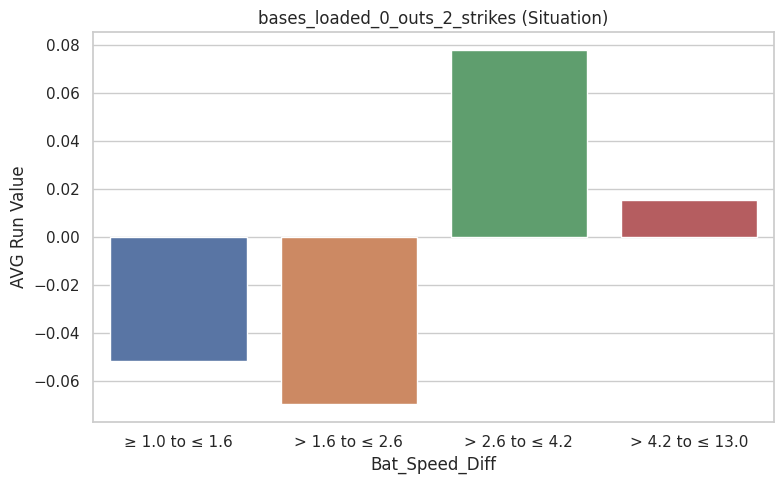


                 Swings
≥ 1.0 to ≤ 1.6       39
> 1.6 to ≤ 2.6       35
> 2.6 to ≤ 4.2       35
> 4.2 to ≤ 13.0      37



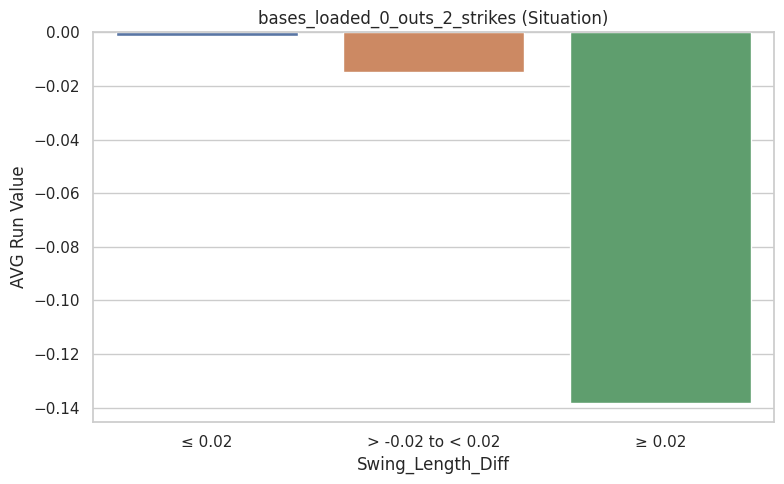


                   Swings
≤ 0.02                304
> -0.02 to < 0.02     198
≥ 0.02                 45



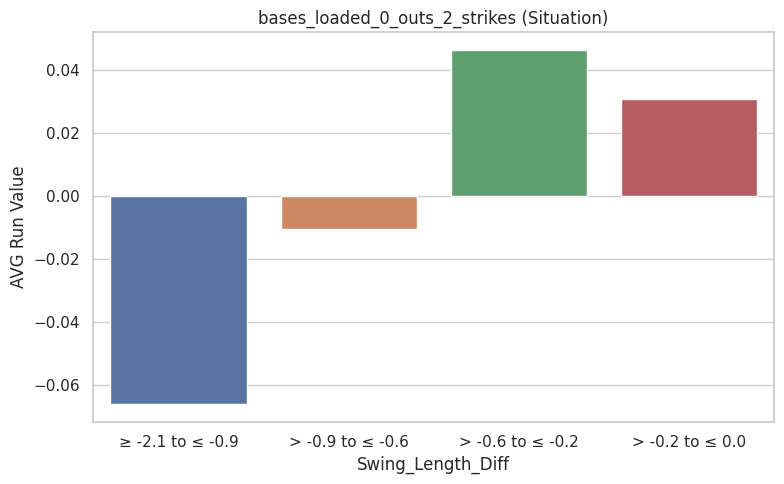


                  Swings
≥ -2.1 to ≤ -0.9      82
> -0.9 to ≤ -0.6      74
> -0.6 to ≤ -0.2      82
> -0.2 to ≤ 0.0       65



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


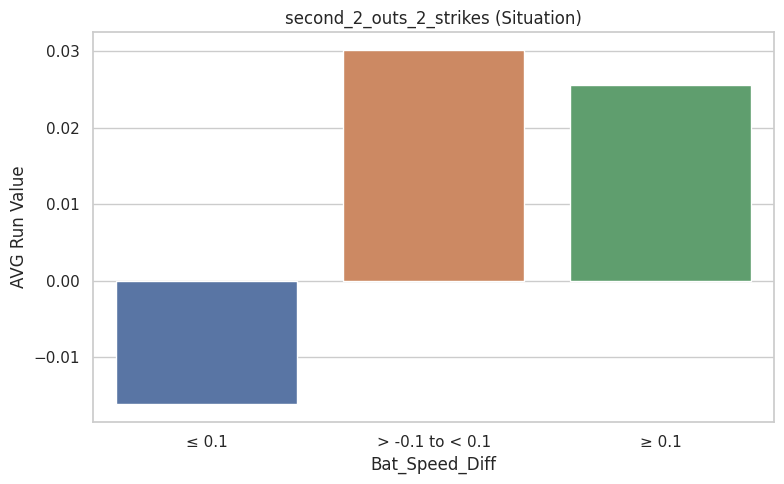


                 Swings
≤ 0.1              3792
> -0.1 to < 0.1     490
≥ 0.1              1771



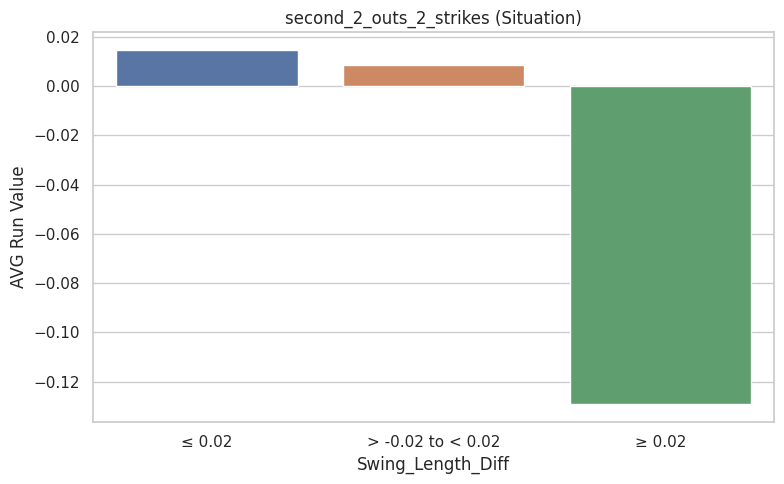


                   Swings
≤ 0.02               3315
> -0.02 to < 0.02    2200
≥ 0.02                532



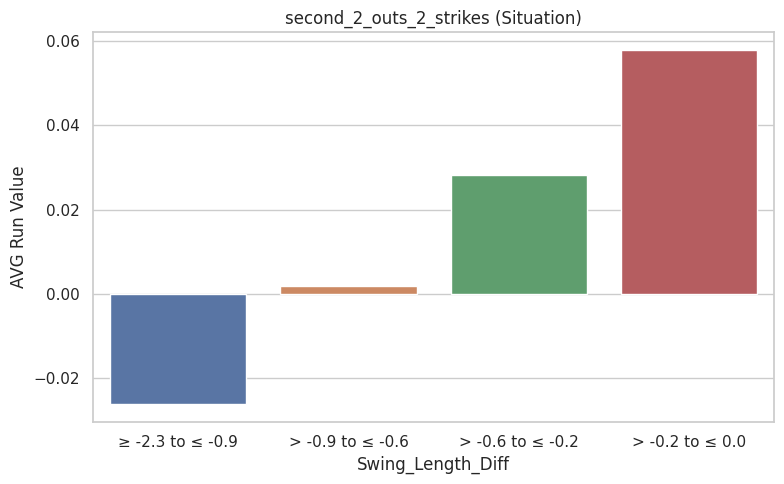


                  Swings
≥ -2.3 to ≤ -0.9     910
> -0.9 to ≤ -0.6     765
> -0.6 to ≤ -0.2     812
> -0.2 to ≤ 0.0      827



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


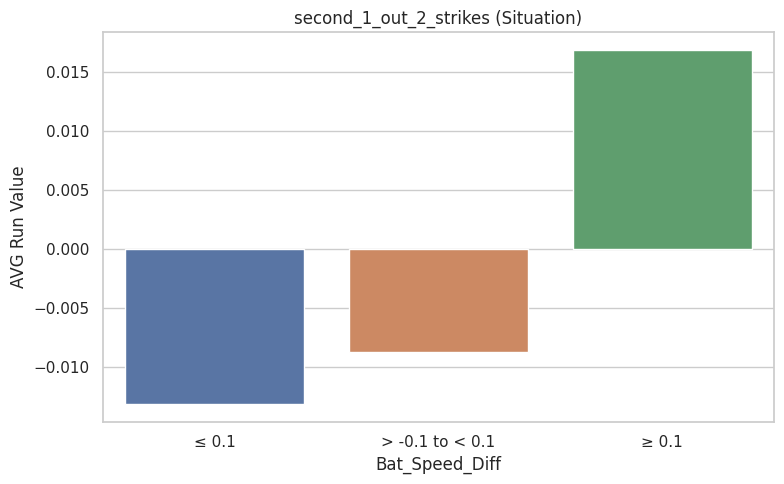


                 Swings
≤ 0.1              2824
> -0.1 to < 0.1     375
≥ 0.1              1392



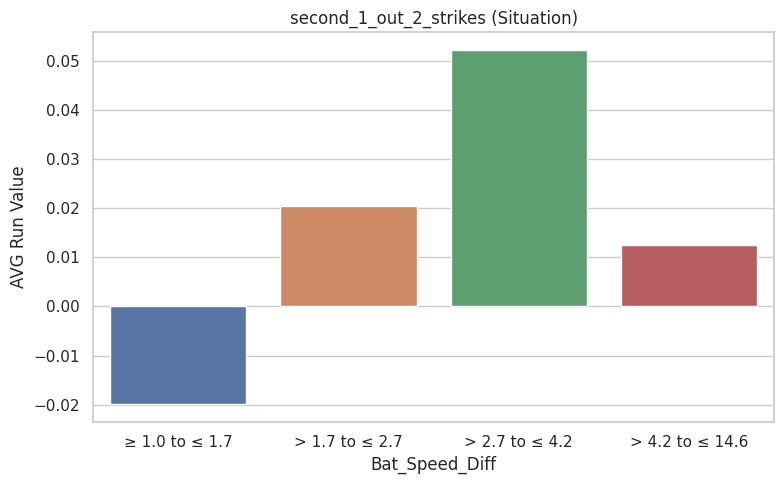


                 Swings
≥ 1.0 to ≤ 1.7      312
> 1.7 to ≤ 2.7      347
> 2.7 to ≤ 4.2      349
> 4.2 to ≤ 14.6     345



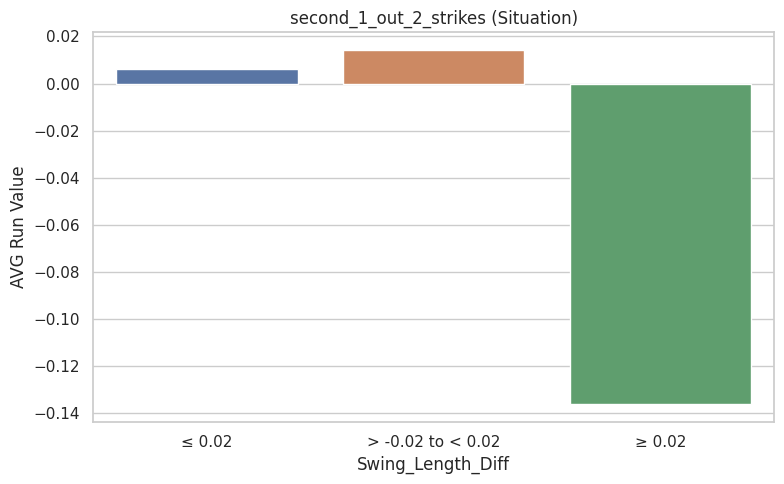


                   Swings
≤ 0.02               2505
> -0.02 to < 0.02    1671
≥ 0.02                413



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


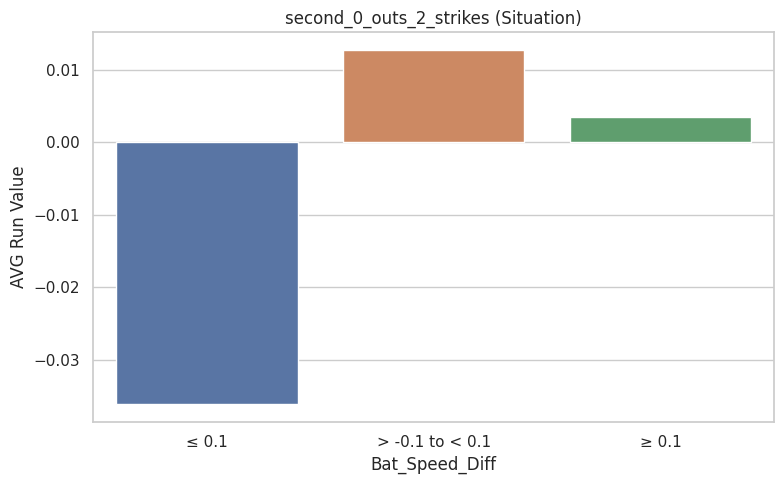


                 Swings
≤ 0.1              1833
> -0.1 to < 0.1     239
≥ 0.1               869



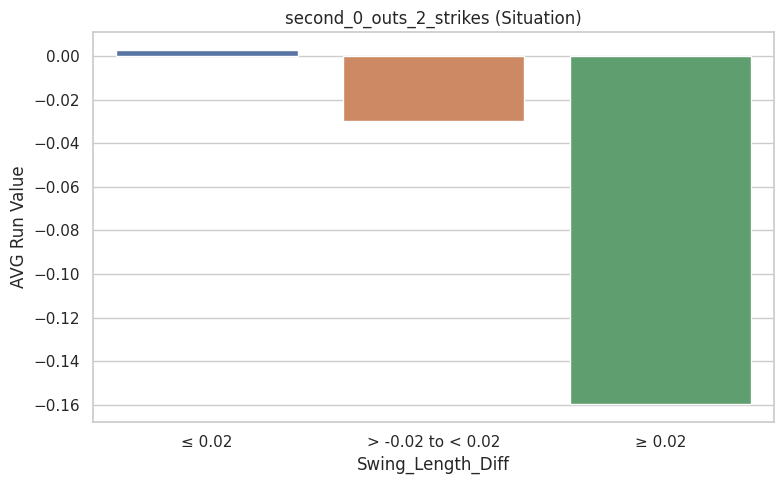


                   Swings
≤ 0.02               1716
> -0.02 to < 0.02    1006
≥ 0.02                219



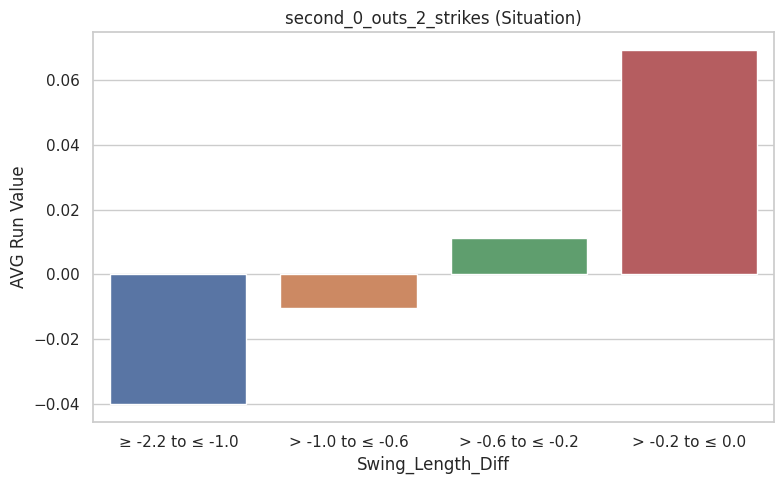


                  Swings
≥ -2.2 to ≤ -1.0     436
> -1.0 to ≤ -0.6     442
> -0.6 to ≤ -0.2     530
> -0.2 to ≤ 0.0      307



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


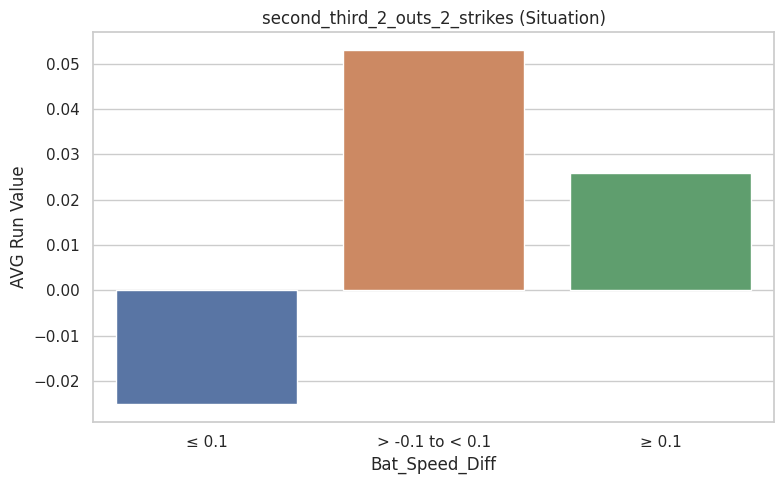


                 Swings
≤ 0.1              1111
> -0.1 to < 0.1     138
≥ 0.1               529



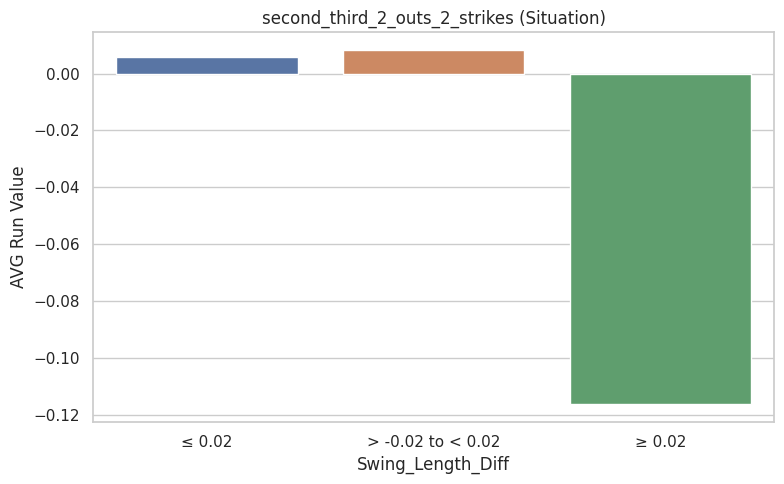


                   Swings
≤ 0.02                986
> -0.02 to < 0.02     639
≥ 0.02                153



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


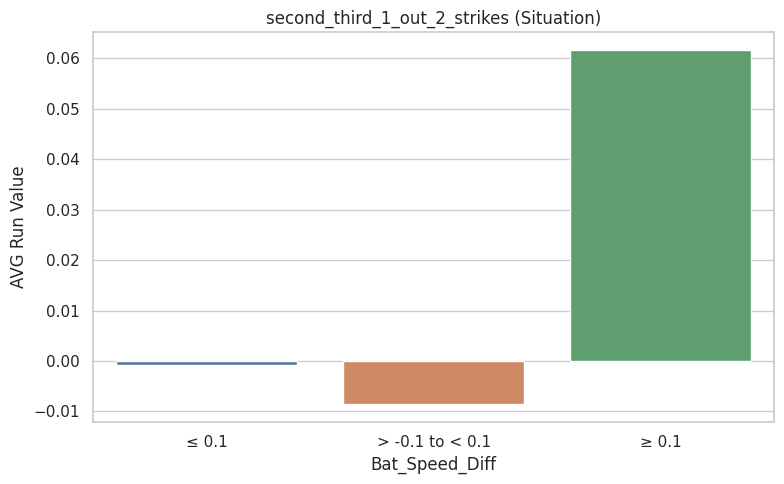


                 Swings
≤ 0.1               797
> -0.1 to < 0.1      86
≥ 0.1               348



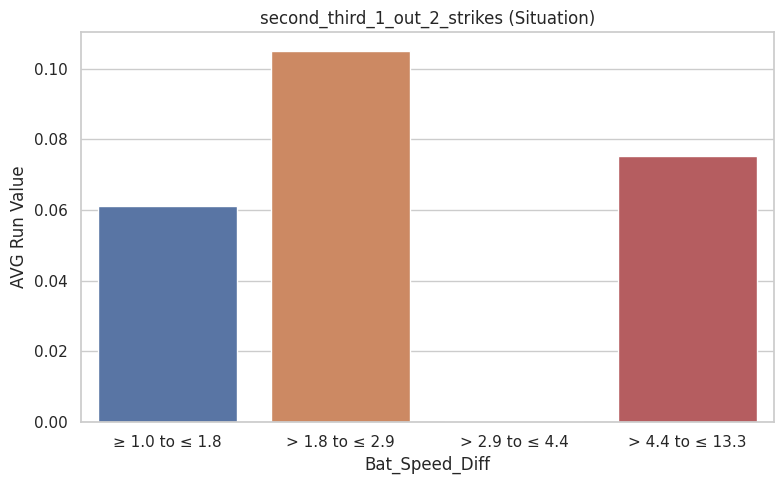


                 Swings
≥ 1.0 to ≤ 1.8       77
> 1.8 to ≤ 2.9       85
> 2.9 to ≤ 4.4       87
> 4.4 to ≤ 13.3      87



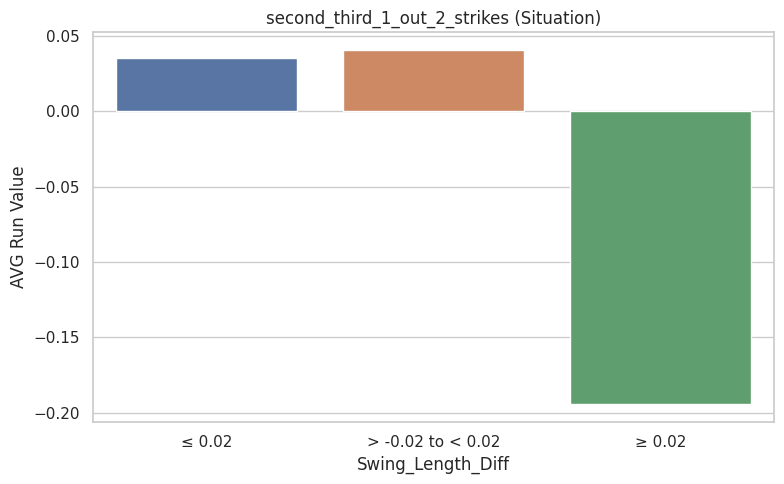


                   Swings
≤ 0.02                676
> -0.02 to < 0.02     442
≥ 0.02                111



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


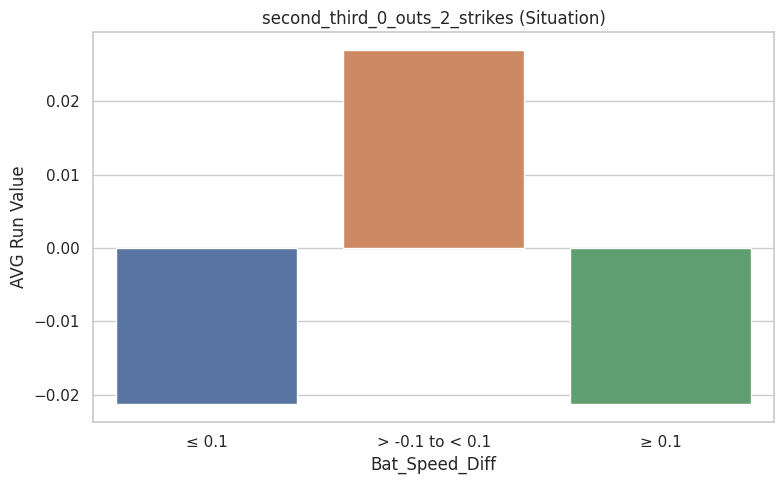


                 Swings
≤ 0.1               354
> -0.1 to < 0.1      47
≥ 0.1               159



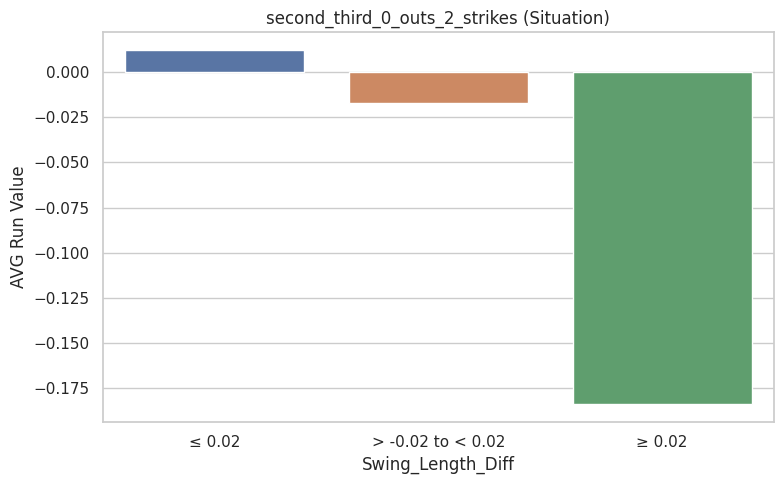


                   Swings
≤ 0.02                318
> -0.02 to < 0.02     185
≥ 0.02                 56



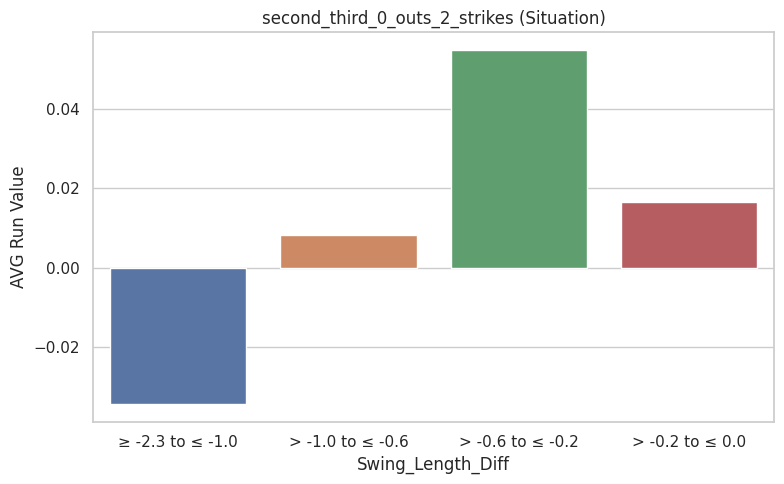


                  Swings
≥ -2.3 to ≤ -1.0      87
> -1.0 to ≤ -0.6      75
> -0.6 to ≤ -0.2      95
> -0.2 to ≤ 0.0       60



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


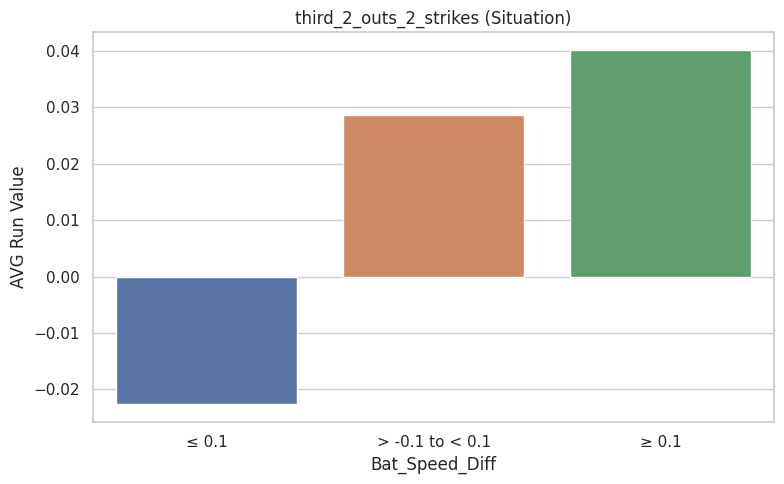


                 Swings
≤ 0.1              1455
> -0.1 to < 0.1     163
≥ 0.1               706



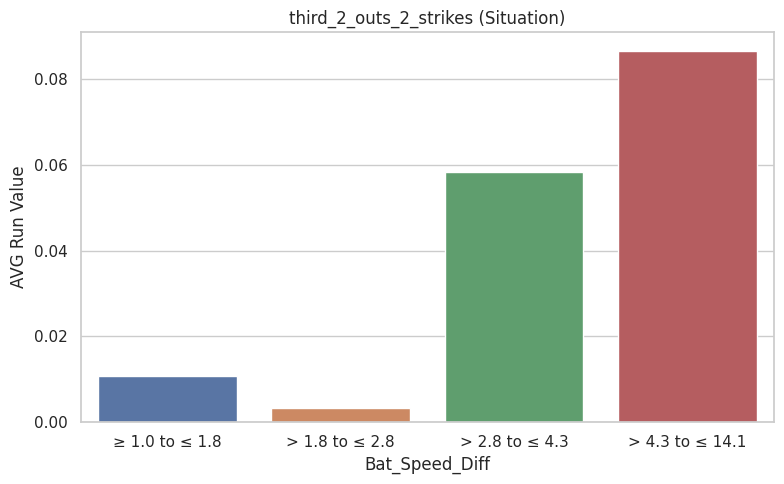


                 Swings
≥ 1.0 to ≤ 1.8      162
> 1.8 to ≤ 2.8      178
> 2.8 to ≤ 4.3      174
> 4.3 to ≤ 14.1     177



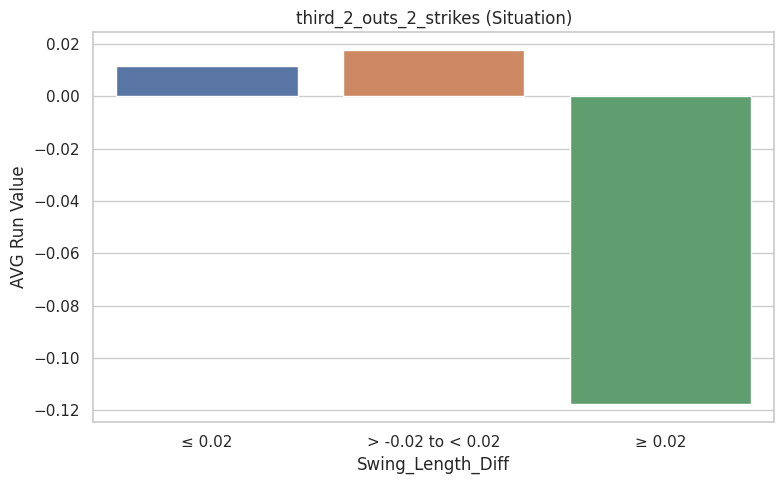


                   Swings
≤ 0.02               1240
> -0.02 to < 0.02     836
≥ 0.02                244



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


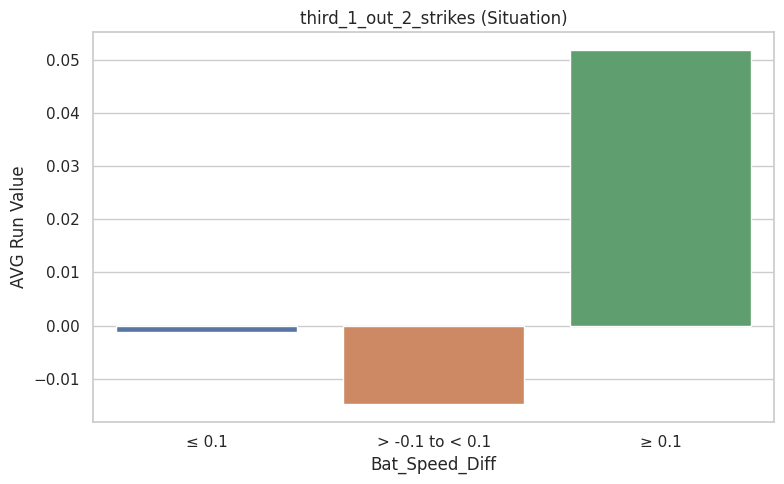


                 Swings
≤ 0.1               934
> -0.1 to < 0.1     103
≥ 0.1               353



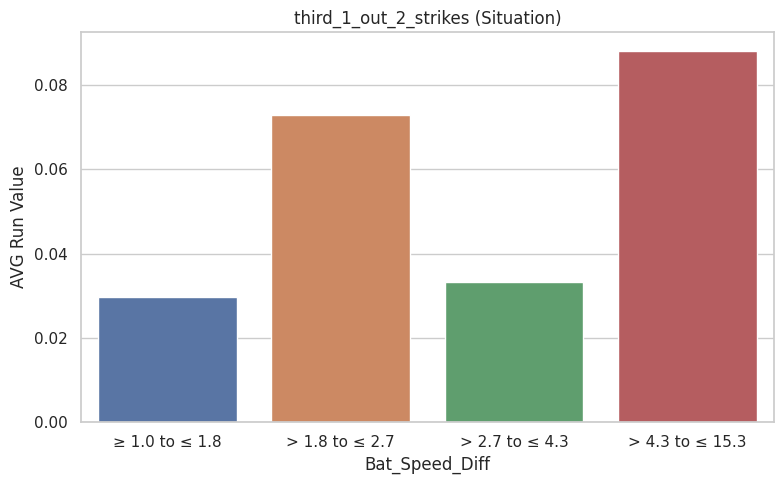


                 Swings
≥ 1.0 to ≤ 1.8       82
> 1.8 to ≤ 2.7       88
> 2.7 to ≤ 4.3       85
> 4.3 to ≤ 15.3      87



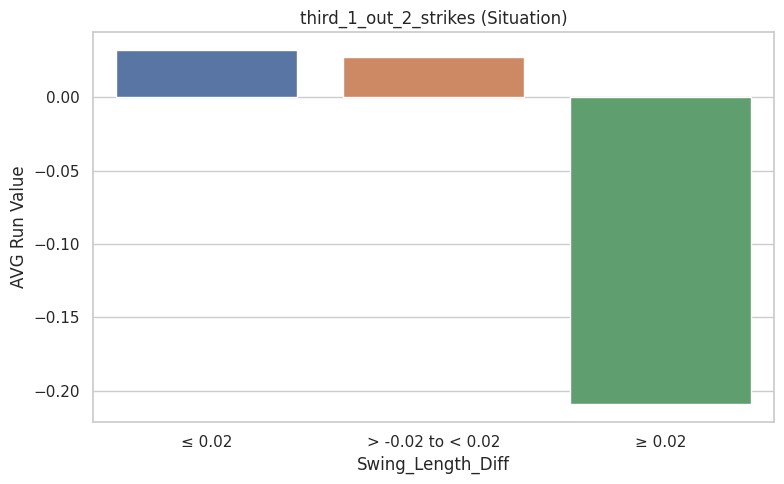


                   Swings
≤ 0.02                789
> -0.02 to < 0.02     488
≥ 0.02                112



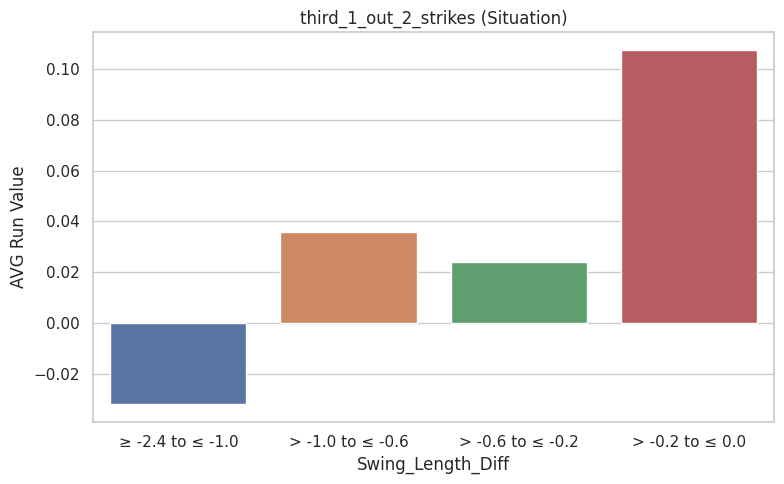


                  Swings
≥ -2.4 to ≤ -1.0     213
> -1.0 to ≤ -0.6     191
> -0.6 to ≤ -0.2     186
> -0.2 to ≤ 0.0      197



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


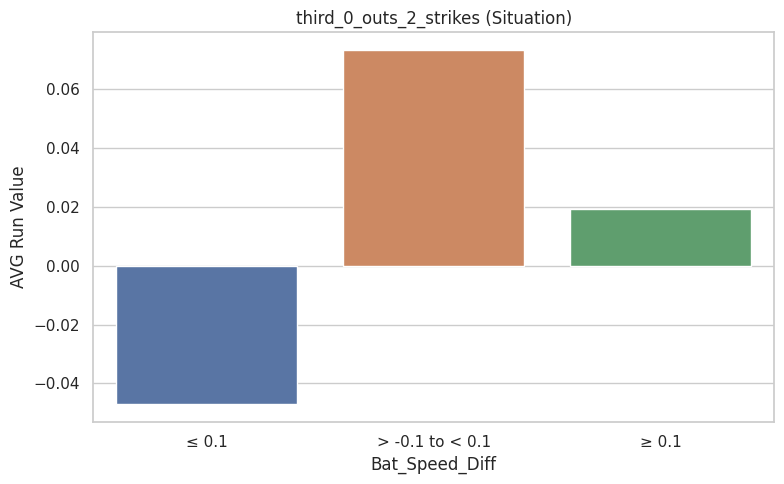


                 Swings
≤ 0.1               235
> -0.1 to < 0.1      21
≥ 0.1               105



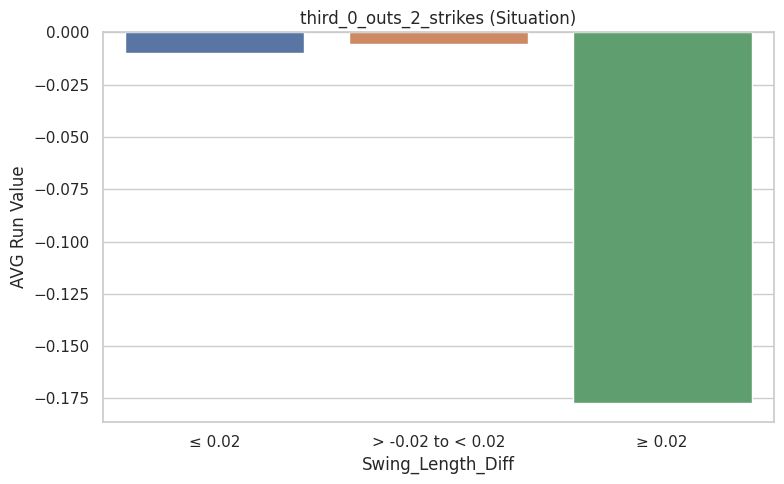


                   Swings
≤ 0.02                197
> -0.02 to < 0.02     137
≥ 0.02                 27



In [20]:
speeds = []
lenghts = []
for i in range(len(list2)):
  title = titles[i]
  speeds, lenghts = graph_run_exp(list2[i], 'Bat_Speed_Diff', speeds, lenghts, title)
  speeds, lenghts = graph_run_exp(list2[i], 'Swing_Length_Diff', speeds, lenghts, title)

In [24]:
two_strike_summary = pd.DataFrame({'Bat Speed (compared to usual)': speeds, 'Swing Length (compared to usual)': lenghts}, index=titles)
print('                             Approach with Best AVG Run Value:')
two_strike_summary

                             Approach with Best AVG Run Value:


,Bat Speed (compared to usual),Swing Length (compared to usual)
first_second_2_outs_2_strikes,Faster,Shorter
first_second_1_out_2_strikes,Faster,Same
first_second_0_outs_2_strikes,Same,Shorter
first_third_2_outs_2_strikes,Faster,Shorter
first_third_1_out_2_strikes,Faster,Same
first_third_0_outs_2_strikes,Faster,Same
bases_loaded_2_outs_2_strikes,Faster,Shorter
bases_loaded_1_out_2_strikes,Faster,Same
bases_loaded_0_outs_2_strikes,Faster,Shorter
second_2_outs_2_strikes,Same,Shorter


# **Table/Graphs of Less Than 2 Strikes RISP Splits**

In [25]:
list1 = [first_second_2_outs_under_2_strikes, first_second_1_out_under_2_strikes, first_second_0_outs_under_2_strikes,
         first_third_2_outs_under_2_strikes, first_third_1_out_under_2_strikes, first_third_0_outs_under_2_strikes,
         bases_loaded_2_outs_under_2_strikes, bases_loaded_1_out_under_2_strikes, bases_loaded_0_outs_under_2_strikes,
         second_2_outs_under_2_strikes, second_1_out_under_2_strikes, second_0_outs_under_2_strikes,
         second_third_2_outs_under_2_strikes, second_third_1_out_under_2_strikes, second_third_0_outs_less_2_strikes,
         third_2_outs_under_2_strikes, third_1_out_under_2_strikes, third_0_outs_under_2_strikes]
titles = ['first_second_2_outs_under_2_strikes', 'first_second_1_out_under_2_strikes', 'first_second_0_outs_under_2_strikes',
         'first_third_2_outs_under_2_strikes', 'first_third_1_out_under_2_strikes', 'first_third_0_outs_under_2_strikes',
         'bases_loaded_2_outs_under_2_strikes', 'bases_loaded_1_out_under_2_strikes', 'bases_loaded_0_outs_under_2_strikes',
         'second_2_outs_under_2_strikes', 'second_1_out_under_2_strikes', 'second_0_outs_under_2_strikes',
         'second_third_2_outs_under_2_strikes', 'second_third_1_out_under_2_strikes', 'second_third_0_outs_less_2_strikes',
         'third_2_outs_under_2_strikes', 'third_1_out_under_2_strikes', 'third_0_outs_under_2_strikes']

/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


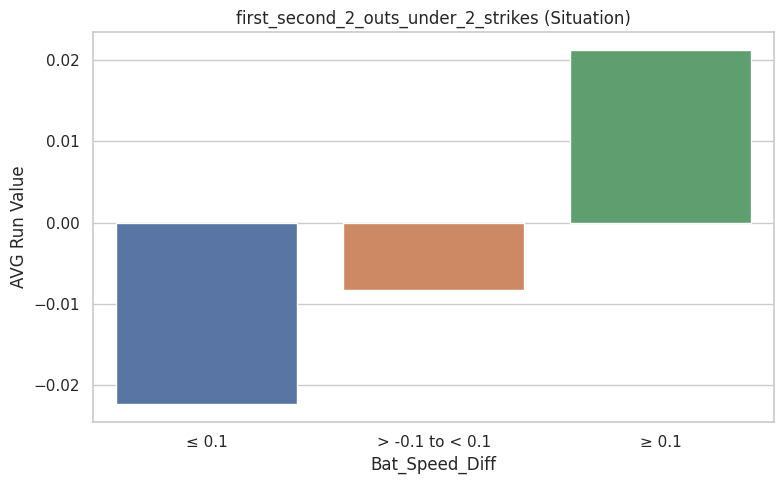


                 Swings
≤ 0.1              3933
> -0.1 to < 0.1     775
≥ 0.1              3752



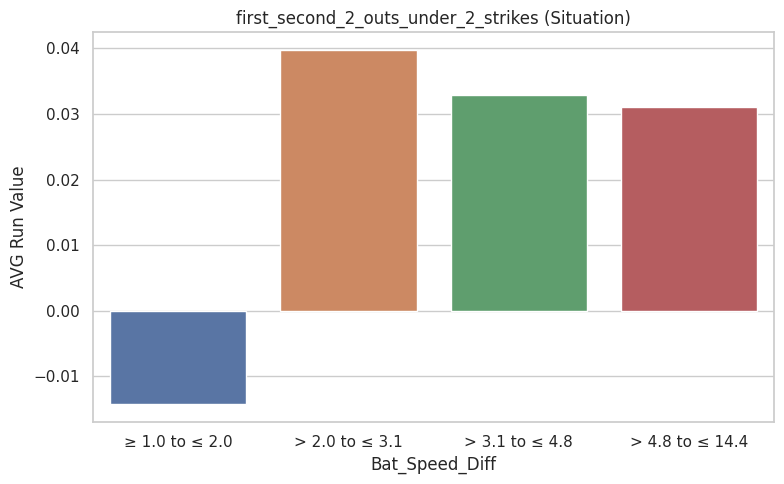


                 Swings
≥ 1.0 to ≤ 2.0      931
> 2.0 to ≤ 3.1      871
> 3.1 to ≤ 4.8      939
> 4.8 to ≤ 14.4     936



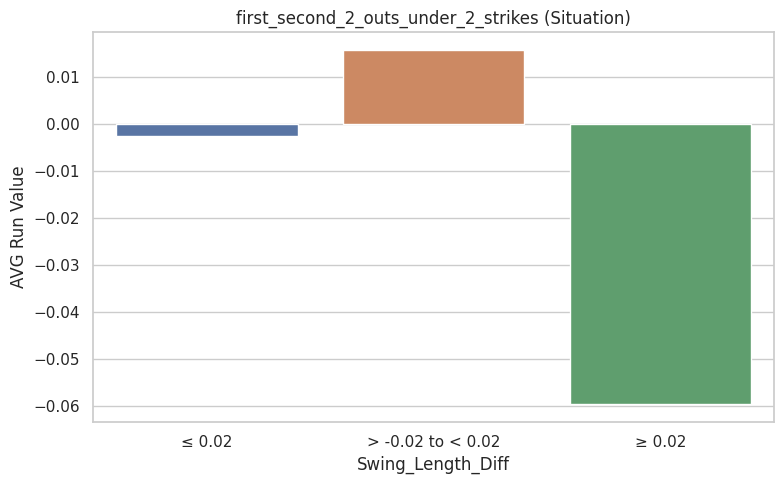


                   Swings
≤ 0.02               4239
> -0.02 to < 0.02    3268
≥ 0.02                943



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


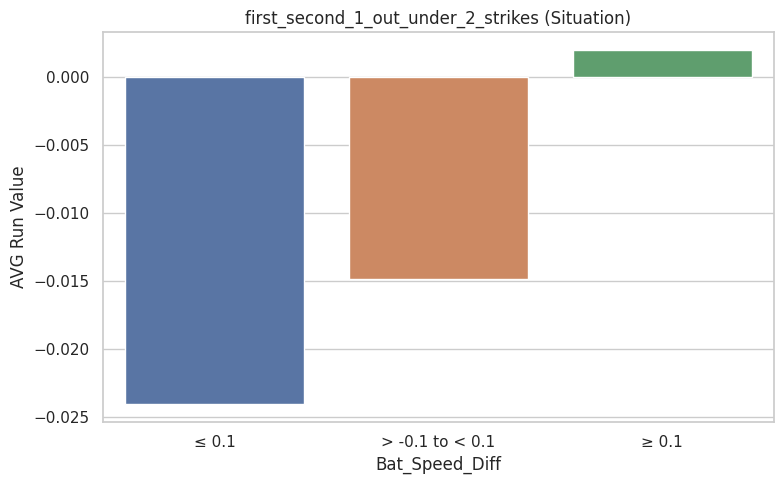


                 Swings
≤ 0.1              3217
> -0.1 to < 0.1     667
≥ 0.1              3239



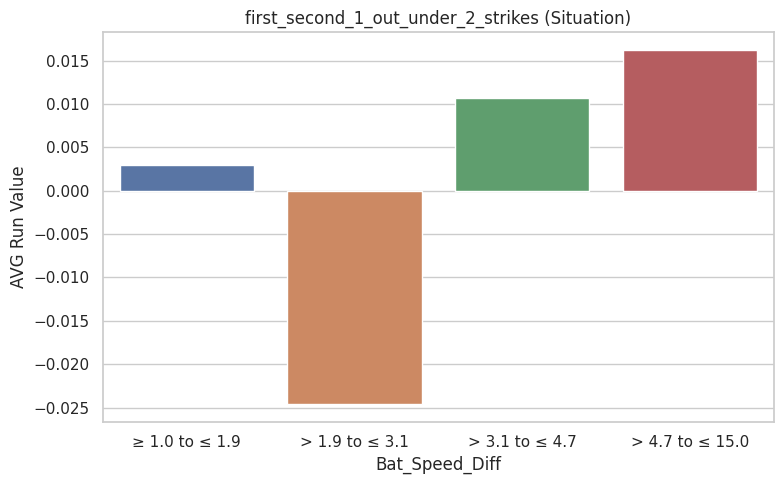


                 Swings
≥ 1.0 to ≤ 1.9      761
> 1.9 to ≤ 3.1      800
> 3.1 to ≤ 4.7      812
> 4.7 to ≤ 15.0     798



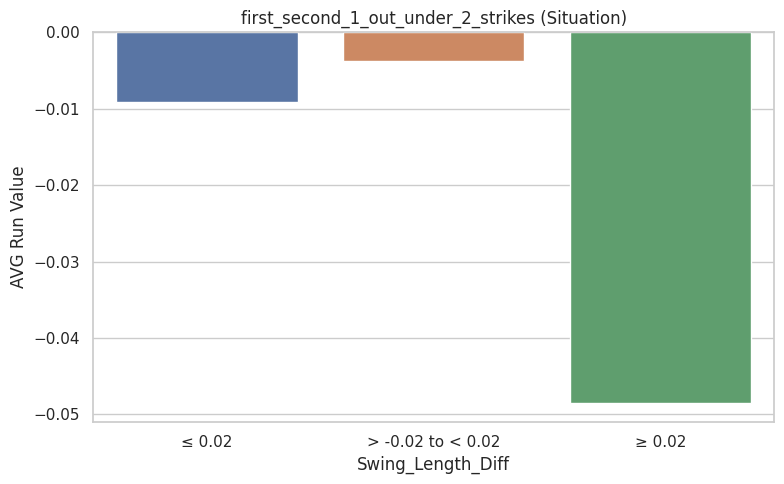


                   Swings
≤ 0.02               3608
> -0.02 to < 0.02    2740
≥ 0.02                771



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


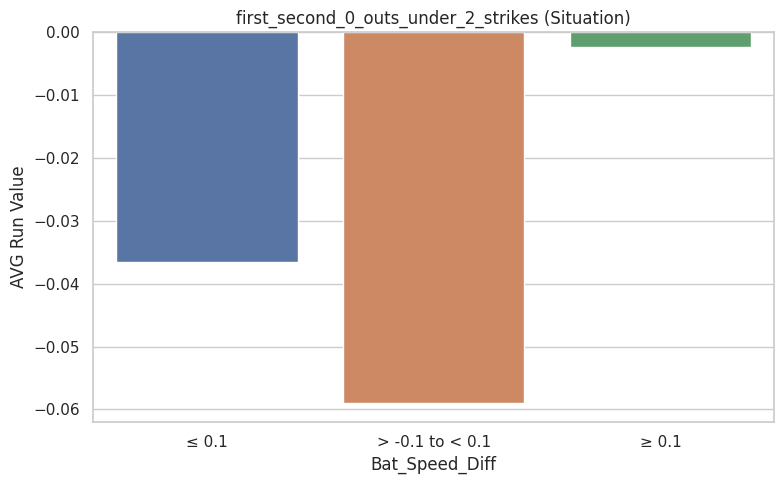


                 Swings
≤ 0.1              1804
> -0.1 to < 0.1     357
≥ 0.1              1756



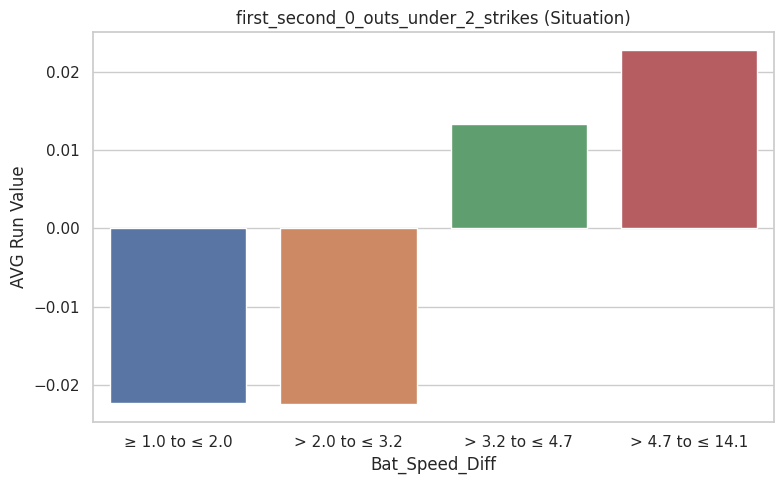


                 Swings
≥ 1.0 to ≤ 2.0      413
> 2.0 to ≤ 3.2      433
> 3.2 to ≤ 4.7      429
> 4.7 to ≤ 14.1     439



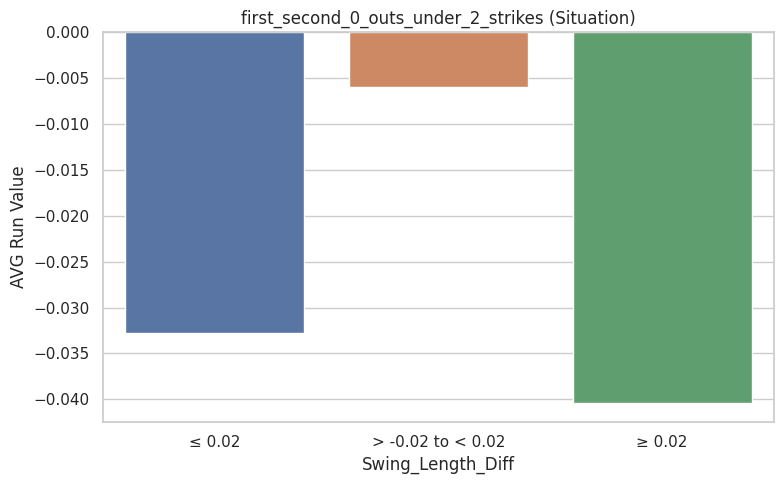


                   Swings
≤ 0.02               2014
> -0.02 to < 0.02    1505
≥ 0.02                397



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


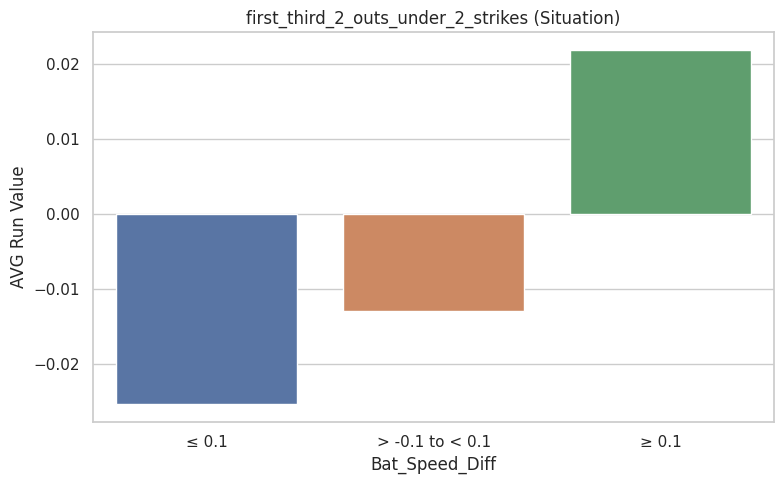


                 Swings
≤ 0.1              2061
> -0.1 to < 0.1     397
≥ 0.1              1796



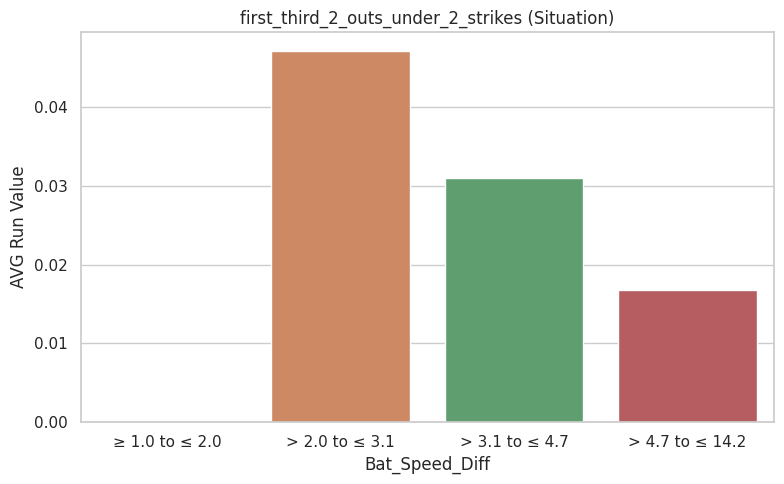


                 Swings
≥ 1.0 to ≤ 2.0      406
> 2.0 to ≤ 3.1      453
> 3.1 to ≤ 4.7      451
> 4.7 to ≤ 14.2     443



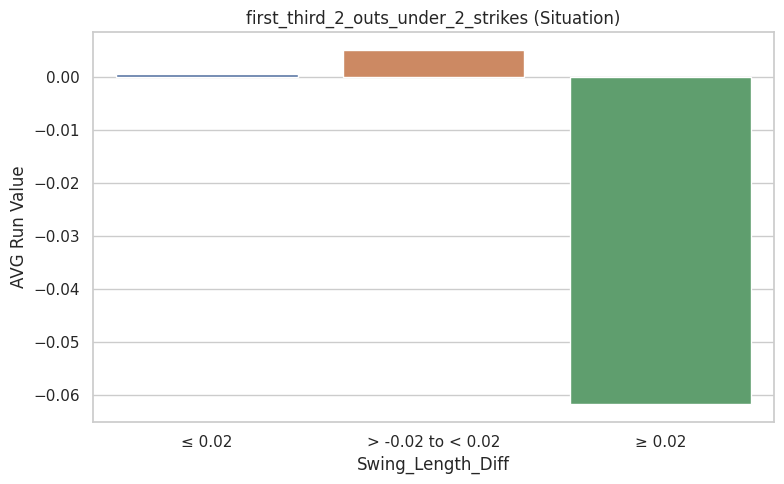


                   Swings
≤ 0.02               2287
> -0.02 to < 0.02    1515
≥ 0.02                448



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


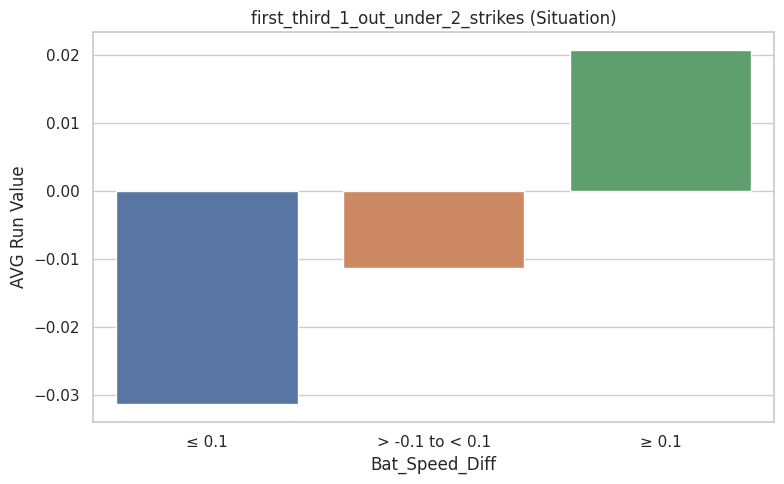


                 Swings
≤ 0.1              1555
> -0.1 to < 0.1     294
≥ 0.1              1288



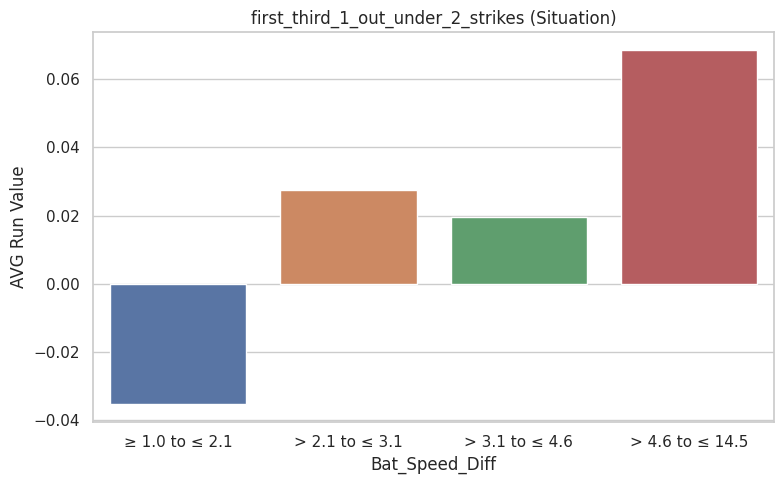


                 Swings
≥ 1.0 to ≤ 2.1      303
> 2.1 to ≤ 3.1      310
> 3.1 to ≤ 4.6      322
> 4.6 to ≤ 14.5     321



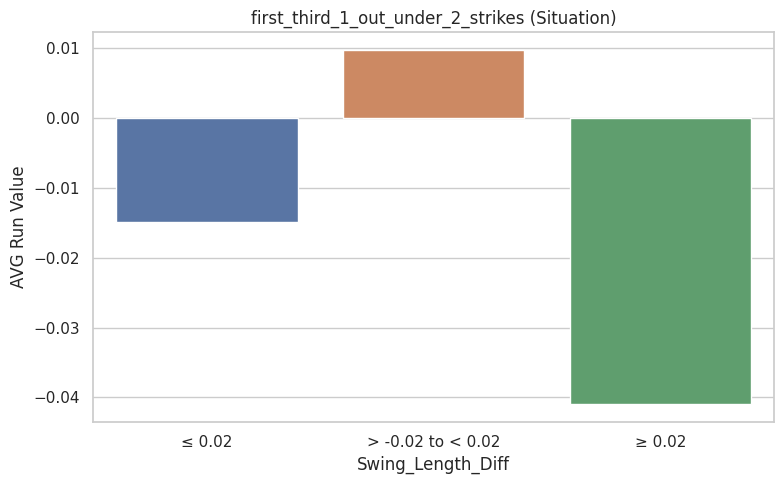


                   Swings
≤ 0.02               1659
> -0.02 to < 0.02    1178
≥ 0.02                298



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


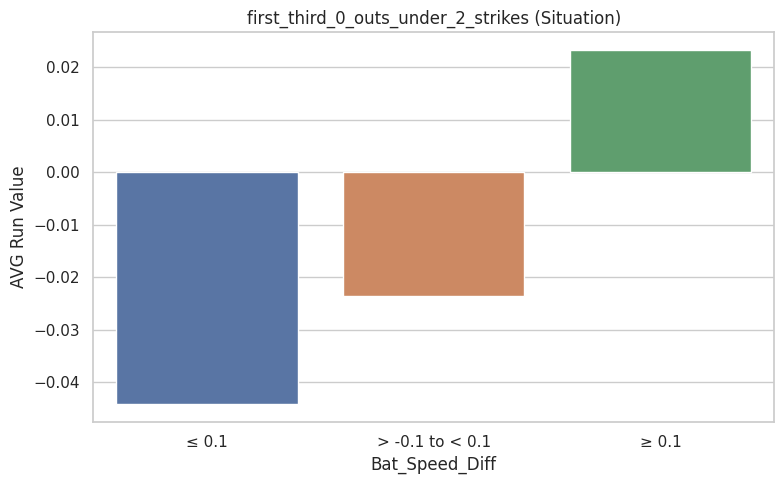


                 Swings
≤ 0.1               798
> -0.1 to < 0.1     137
≥ 0.1               635



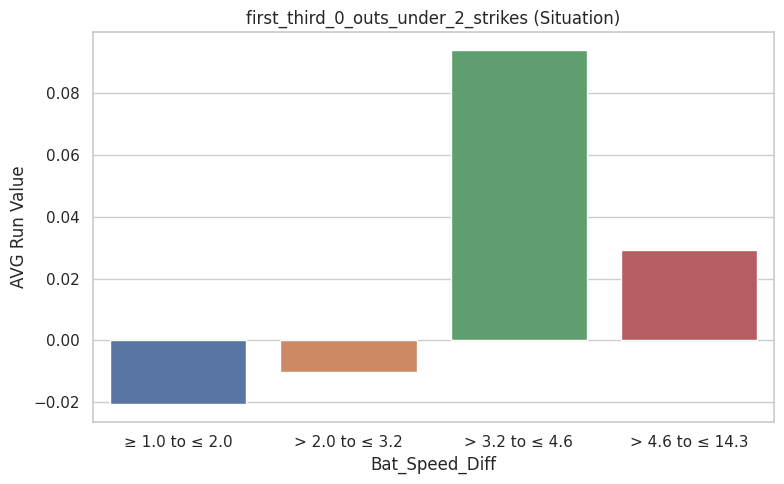


                 Swings
≥ 1.0 to ≤ 2.0      143
> 2.0 to ≤ 3.2      160
> 3.2 to ≤ 4.6      157
> 4.6 to ≤ 14.3     156



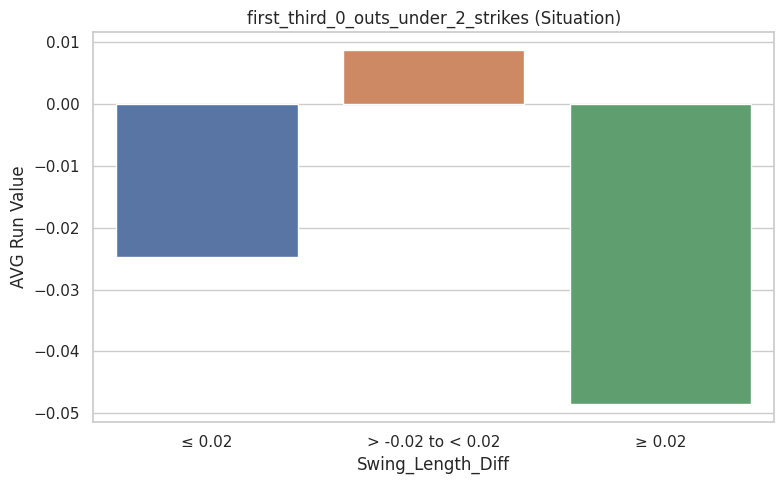


                   Swings
≤ 0.02                864
> -0.02 to < 0.02     559
≥ 0.02                146



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


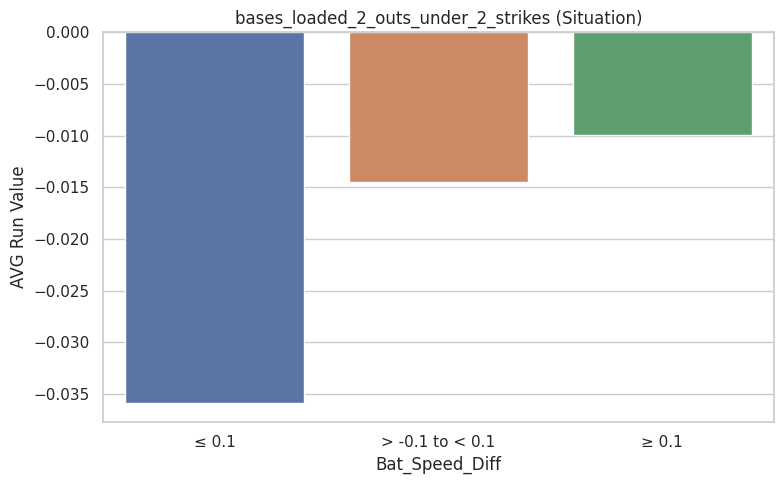


                 Swings
≤ 0.1              1356
> -0.1 to < 0.1     282
≥ 0.1              1333



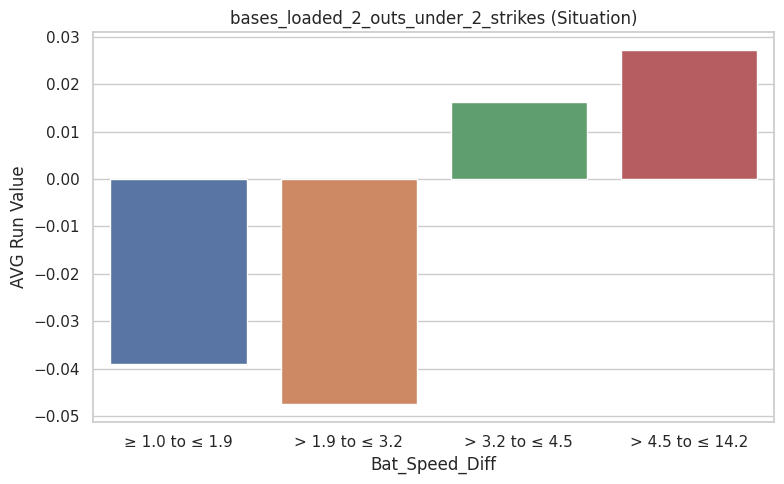


                 Swings
≥ 1.0 to ≤ 1.9      302
> 1.9 to ≤ 3.2      334
> 3.2 to ≤ 4.5      333
> 4.5 to ≤ 14.2     332



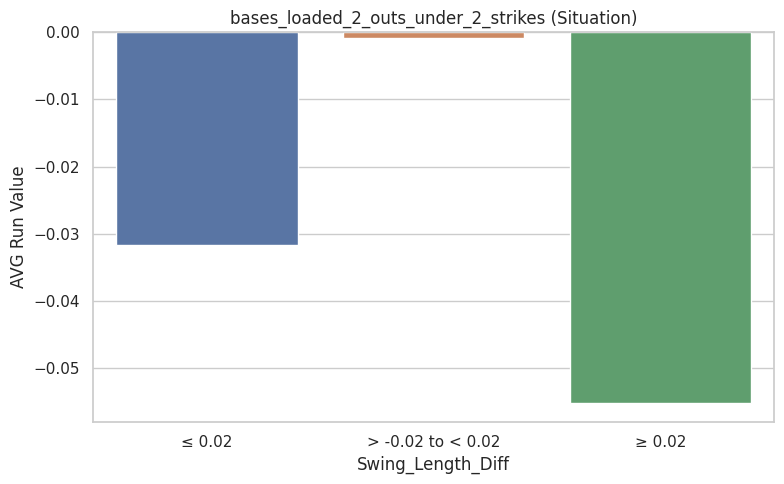


                   Swings
≤ 0.02               1515
> -0.02 to < 0.02    1145
≥ 0.02                311



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


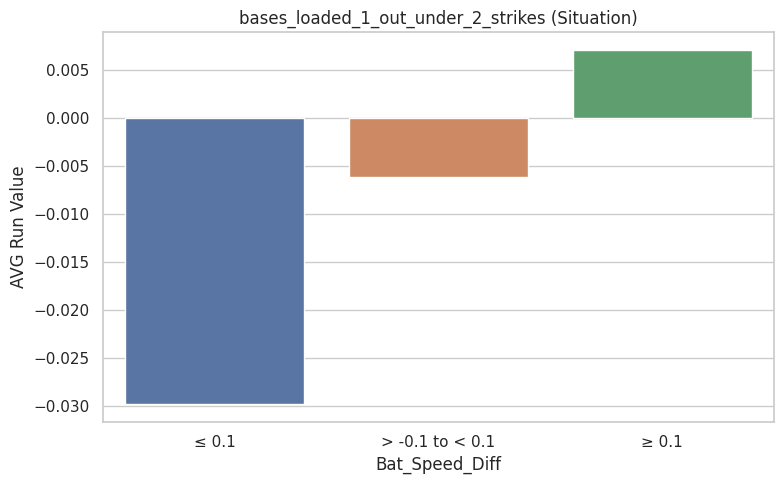


                 Swings
≤ 0.1              1282
> -0.1 to < 0.1     193
≥ 0.1              1102



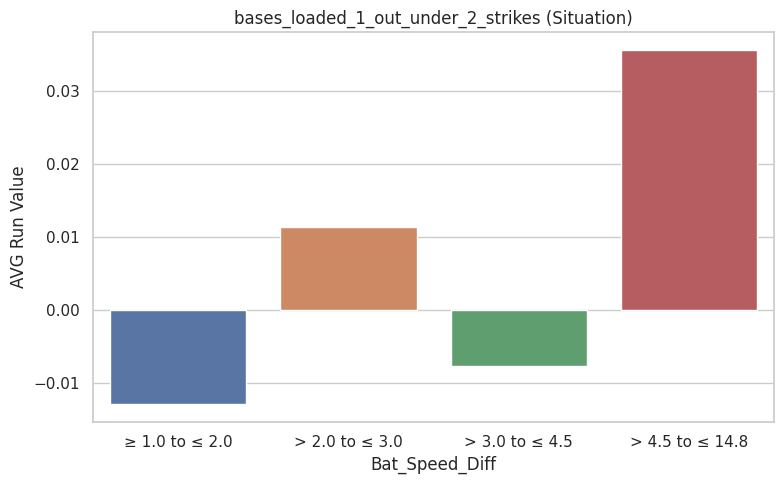


                 Swings
≥ 1.0 to ≤ 2.0      262
> 2.0 to ≤ 3.0      268
> 3.0 to ≤ 4.5      272
> 4.5 to ≤ 14.8     274



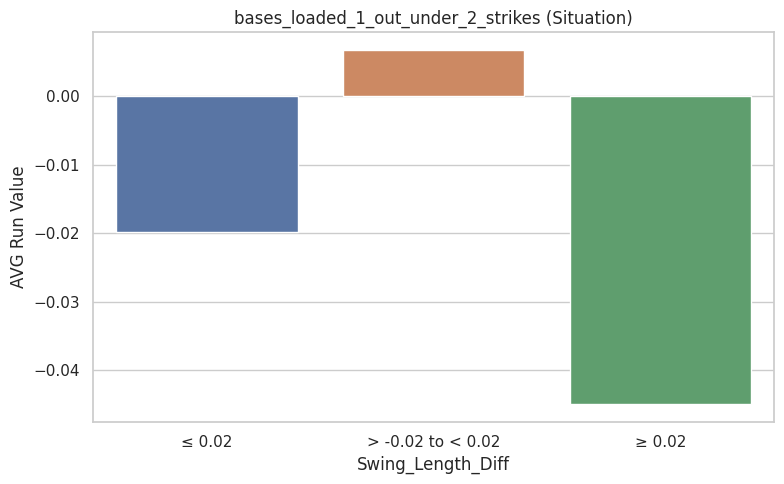


                   Swings
≤ 0.02               1339
> -0.02 to < 0.02     980
≥ 0.02                255



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


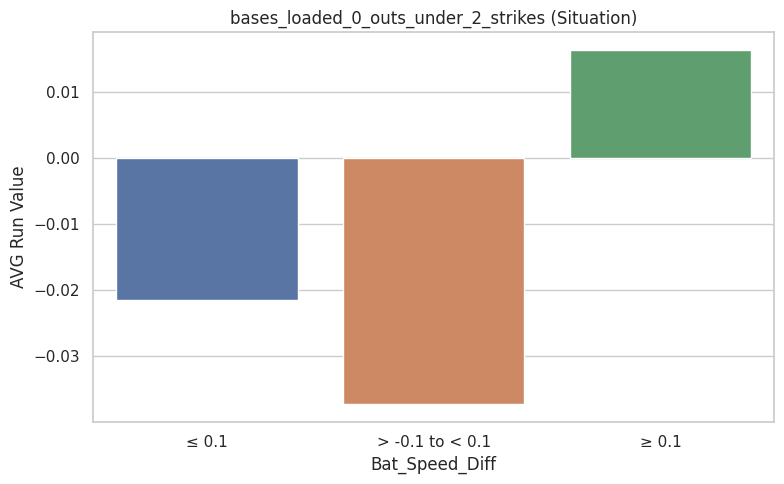


                 Swings
≤ 0.1               591
> -0.1 to < 0.1     105
≥ 0.1               503



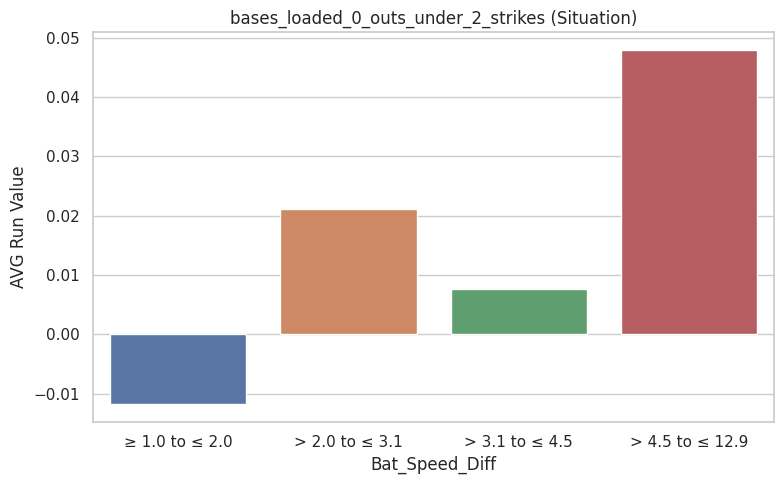


                 Swings
≥ 1.0 to ≤ 2.0      112
> 2.0 to ≤ 3.1      126
> 3.1 to ≤ 4.5      126
> 4.5 to ≤ 12.9     125



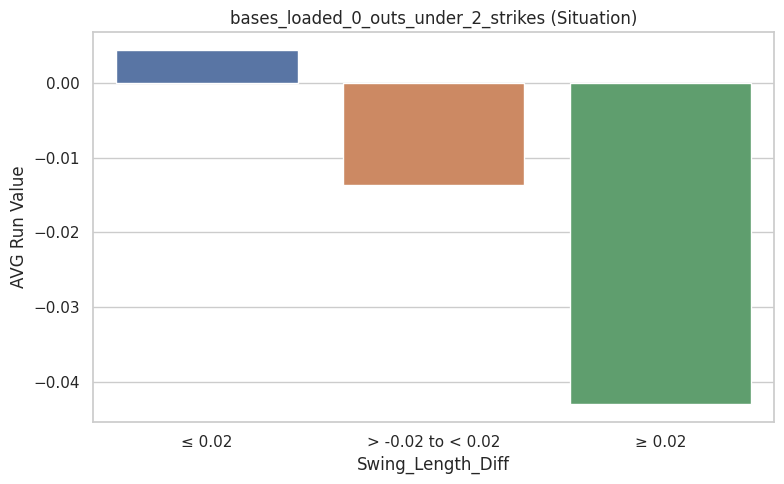


                   Swings
≤ 0.02                640
> -0.02 to < 0.02     446
≥ 0.02                112



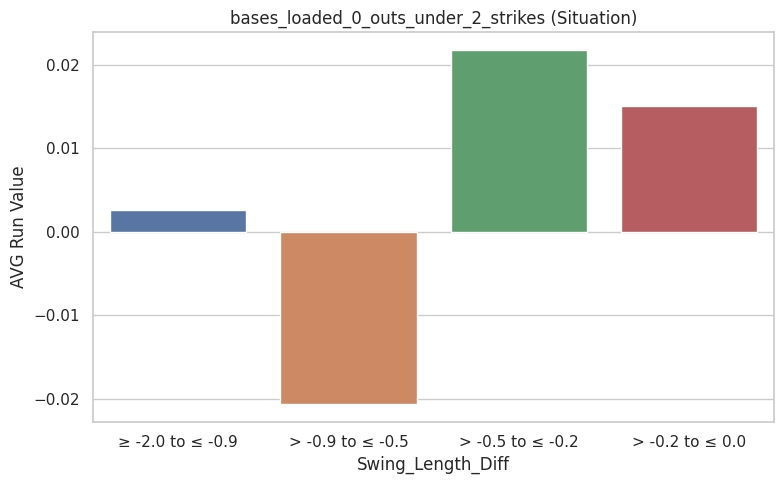


                  Swings
≥ -2.0 to ≤ -0.9     168
> -0.9 to ≤ -0.5     157
> -0.5 to ≤ -0.2     168
> -0.2 to ≤ 0.0      146



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


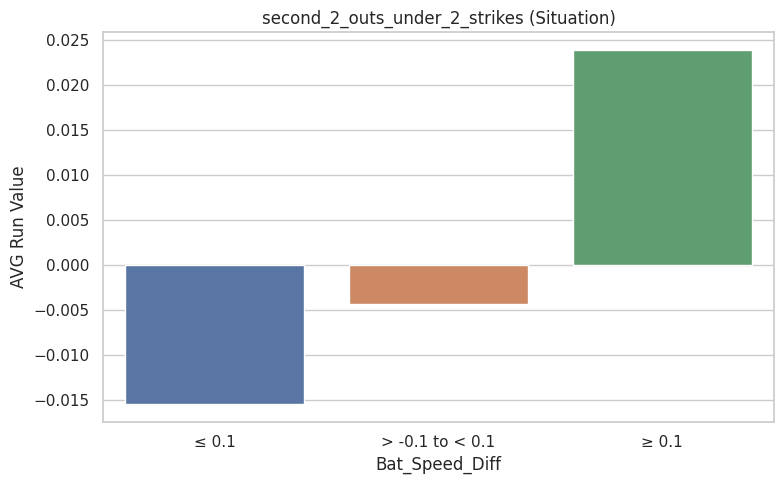


                 Swings
≤ 0.1              4529
> -0.1 to < 0.1     855
≥ 0.1              4027



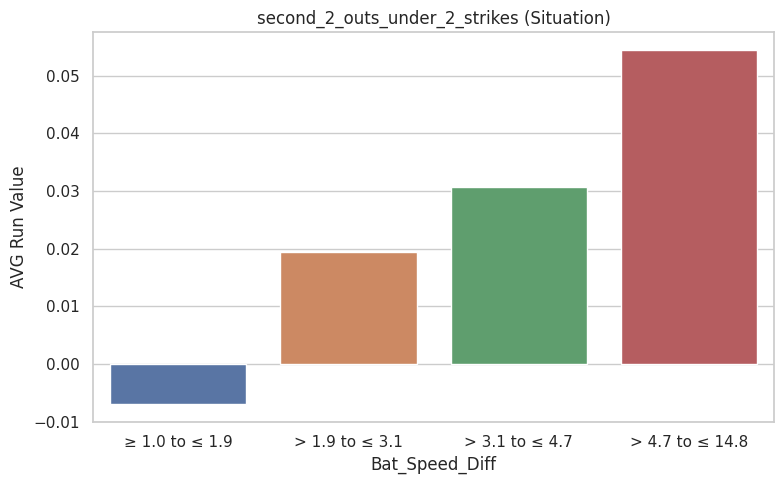


                 Swings
≥ 1.0 to ≤ 1.9      915
> 1.9 to ≤ 3.1     1021
> 3.1 to ≤ 4.7      995
> 4.7 to ≤ 14.8    1003



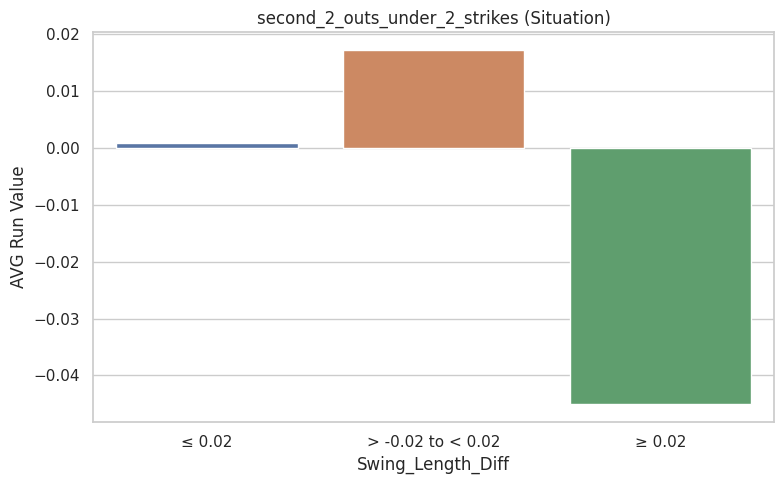


                   Swings
≤ 0.02               4834
> -0.02 to < 0.02    3579
≥ 0.02                990



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


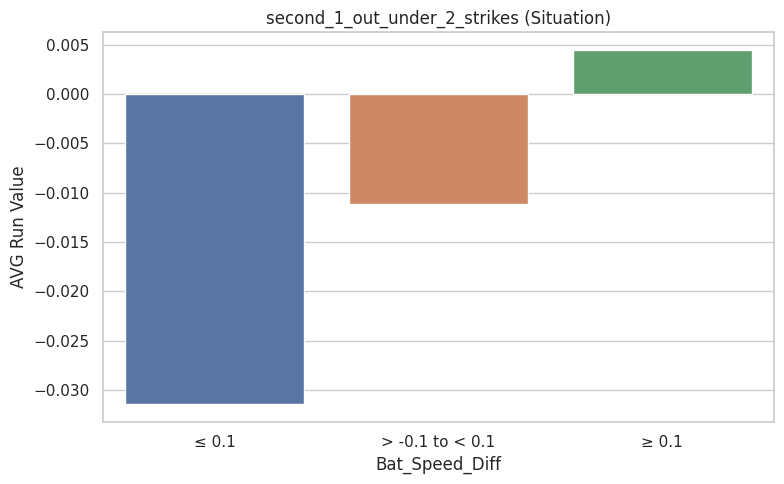


                 Swings
≤ 0.1              3421
> -0.1 to < 0.1     711
≥ 0.1              3368



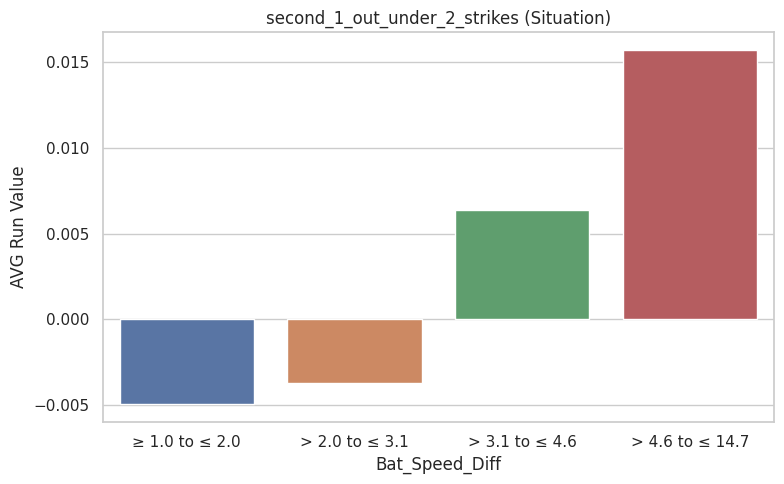


                 Swings
≥ 1.0 to ≤ 2.0      843
> 2.0 to ≤ 3.1      794
> 3.1 to ≤ 4.6      821
> 4.6 to ≤ 14.7     839



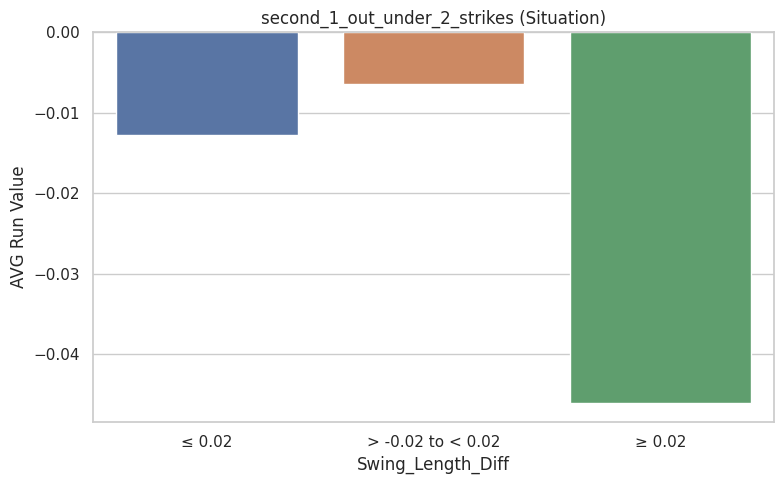


                   Swings
≤ 0.02               3879
> -0.02 to < 0.02    2897
≥ 0.02                715



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


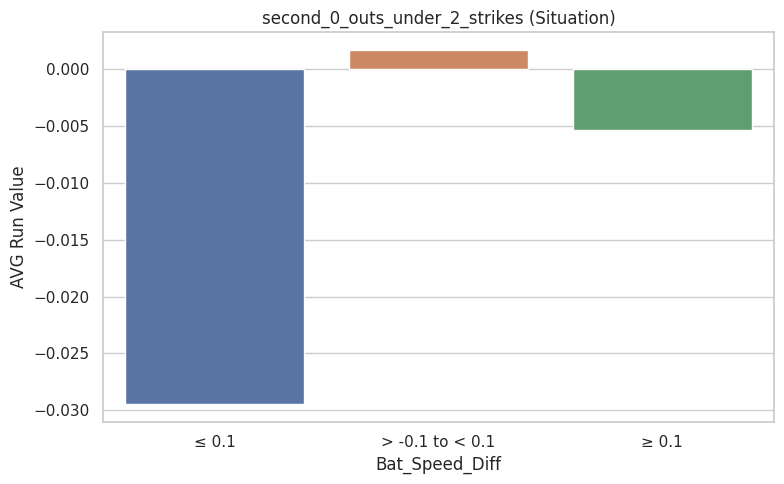


                 Swings
≤ 0.1              2584
> -0.1 to < 0.1     444
≥ 0.1              1985



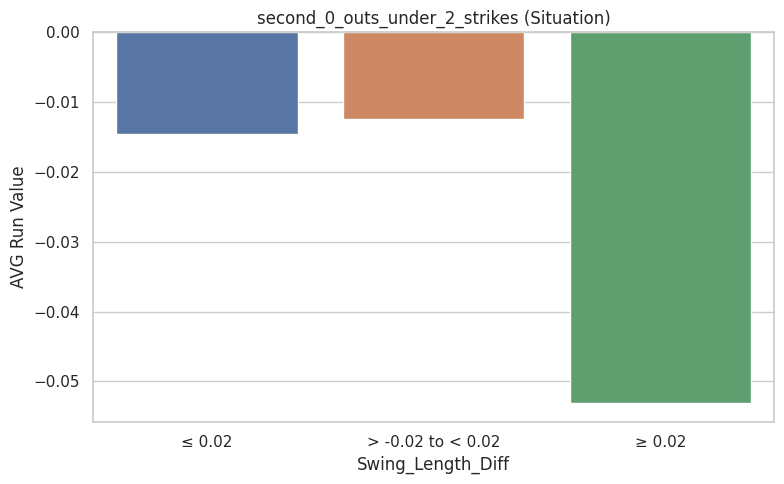


                   Swings
≤ 0.02               2839
> -0.02 to < 0.02    1705
≥ 0.02                466



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


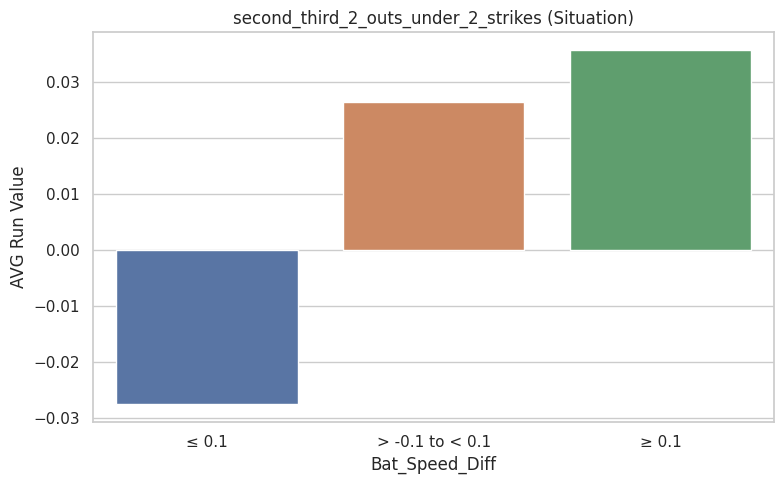


                 Swings
≤ 0.1              1180
> -0.1 to < 0.1     245
≥ 0.1              1009



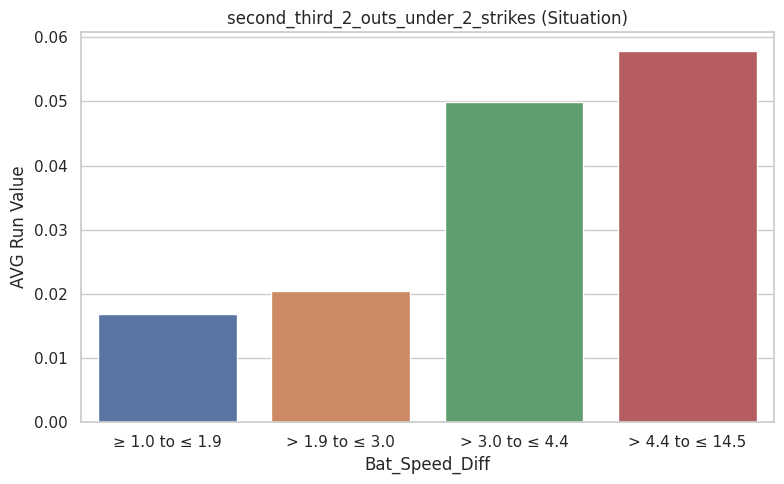


                 Swings
≥ 1.0 to ≤ 1.9      243
> 1.9 to ≤ 3.0      249
> 3.0 to ≤ 4.4      239
> 4.4 to ≤ 14.5     251



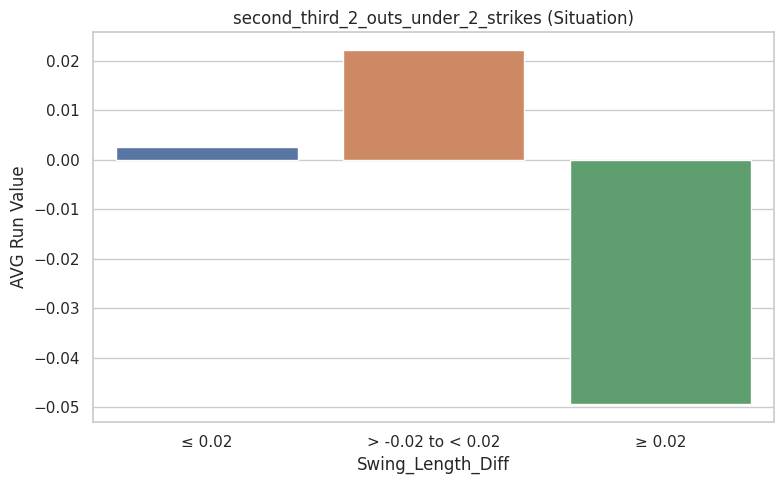


                   Swings
≤ 0.02               1269
> -0.02 to < 0.02     884
≥ 0.02                280



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


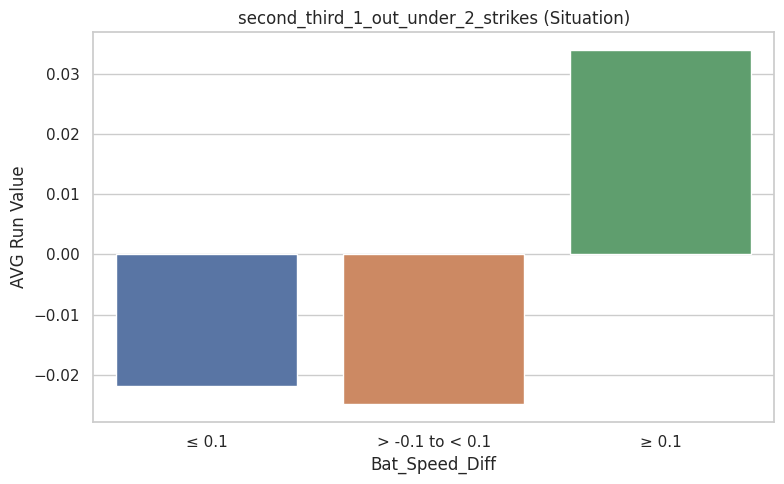


                 Swings
≤ 0.1              1158
> -0.1 to < 0.1     182
≥ 0.1               832



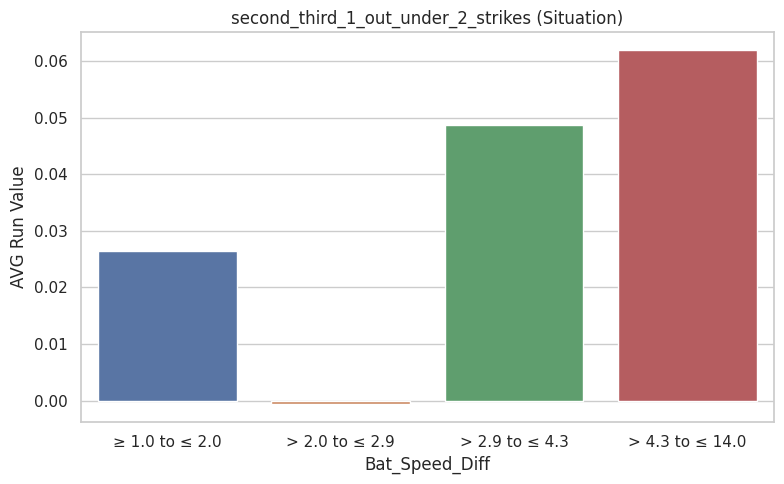


                 Swings
≥ 1.0 to ≤ 2.0      185
> 2.0 to ≤ 2.9      215
> 2.9 to ≤ 4.3      203
> 4.3 to ≤ 14.0     204



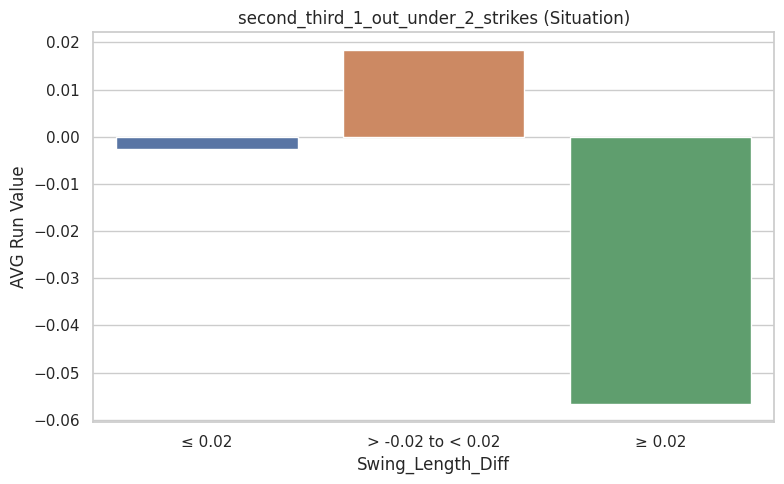


                   Swings
≤ 0.02               1173
> -0.02 to < 0.02     775
≥ 0.02                222



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


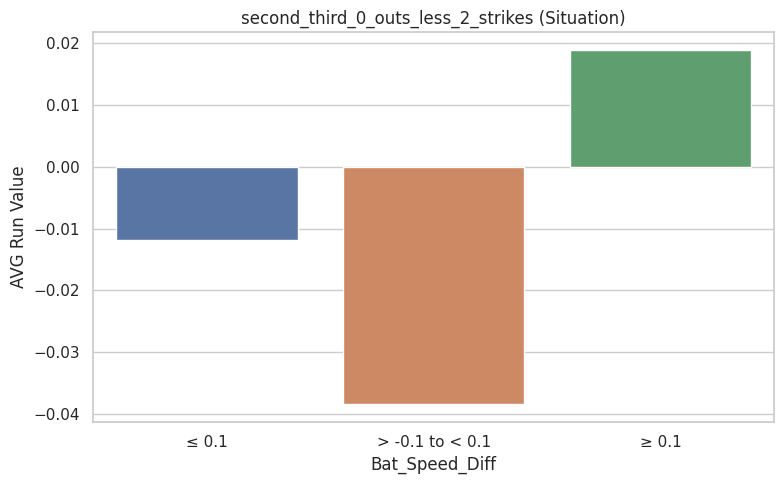


                 Swings
≤ 0.1               544
> -0.1 to < 0.1      97
≥ 0.1               431



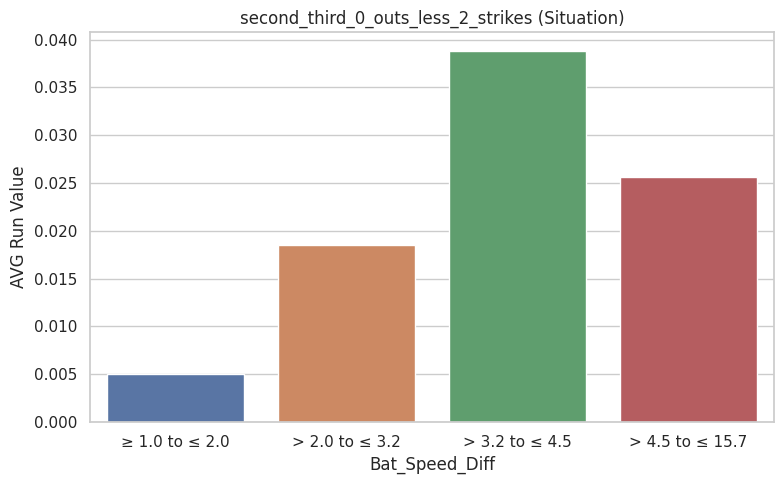


                 Swings
≥ 1.0 to ≤ 2.0       98
> 2.0 to ≤ 3.2      108
> 3.2 to ≤ 4.5      108
> 4.5 to ≤ 15.7     107



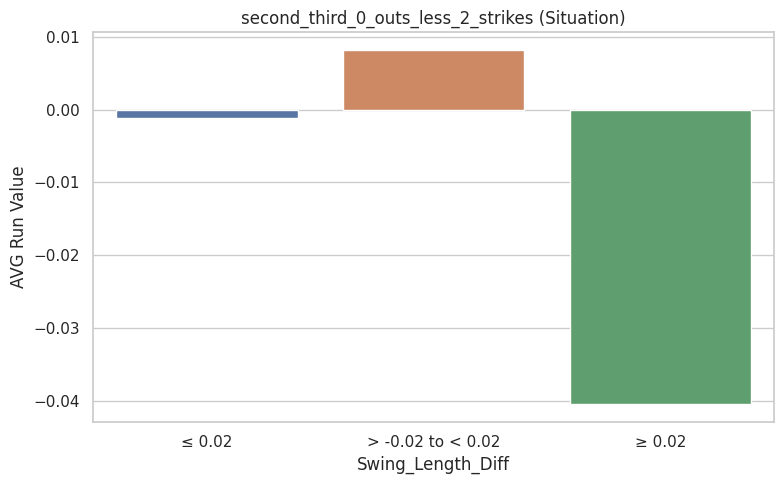


                   Swings
≤ 0.02                546
> -0.02 to < 0.02     409
≥ 0.02                117



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


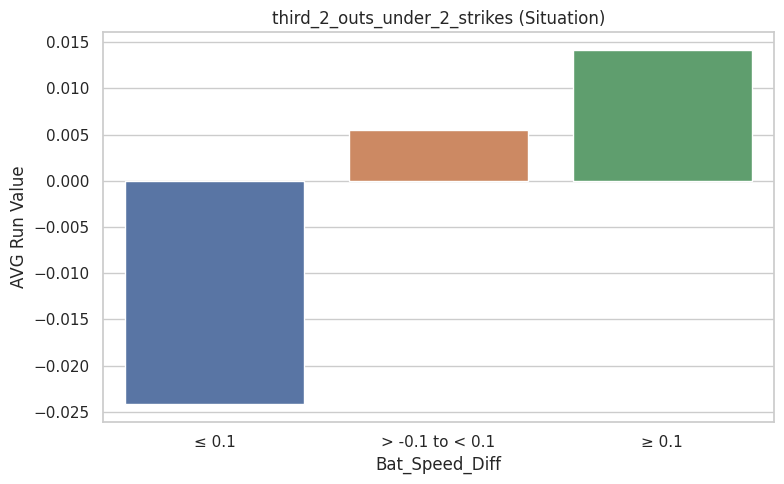


                 Swings
≤ 0.1              1860
> -0.1 to < 0.1     358
≥ 0.1              1718



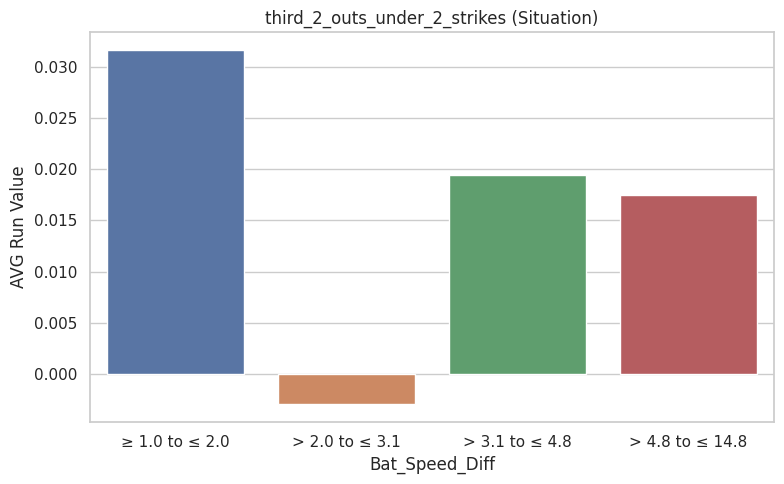


                 Swings
≥ 1.0 to ≤ 2.0      426
> 2.0 to ≤ 3.1      409
> 3.1 to ≤ 4.8      427
> 4.8 to ≤ 14.8     430



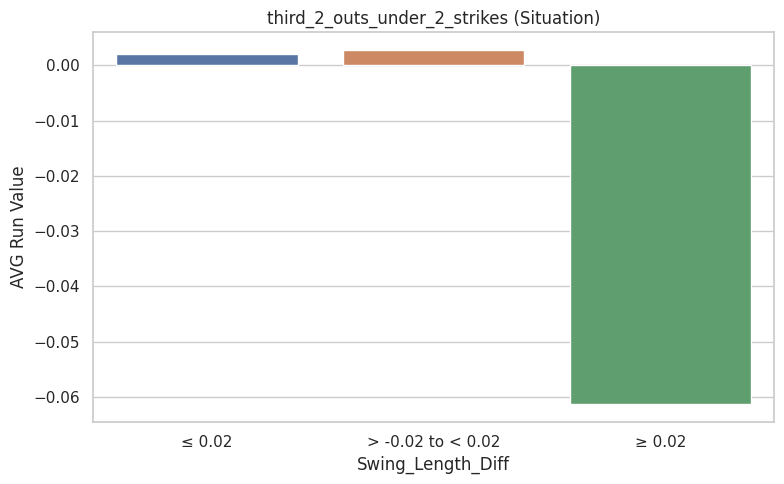


                   Swings
≤ 0.02               2033
> -0.02 to < 0.02    1466
≥ 0.02                430



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


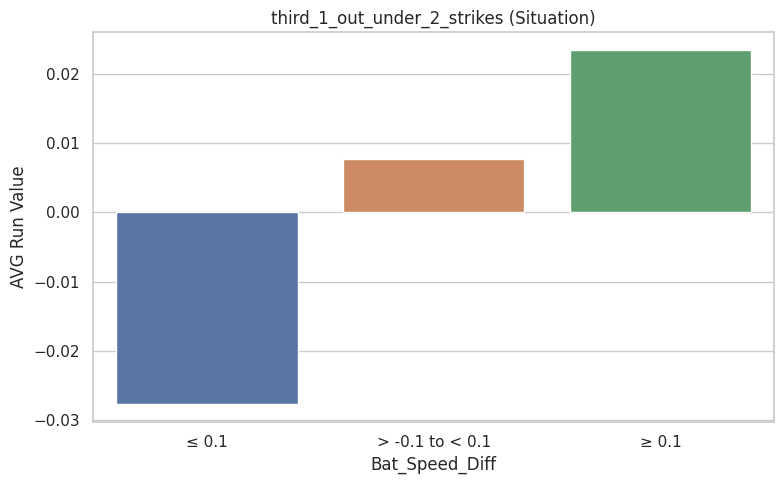


                 Swings
≤ 0.1              1398
> -0.1 to < 0.1     217
≥ 0.1               998



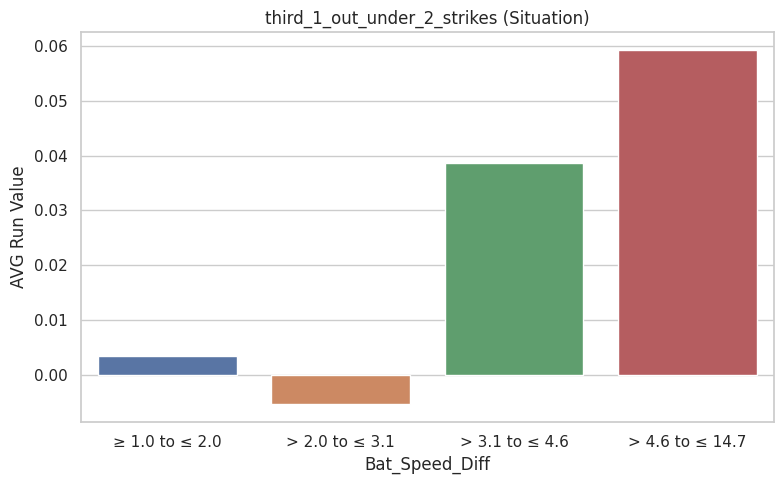


                 Swings
≥ 1.0 to ≤ 2.0      257
> 2.0 to ≤ 3.1      237
> 3.1 to ≤ 4.6      241
> 4.6 to ≤ 14.7     245



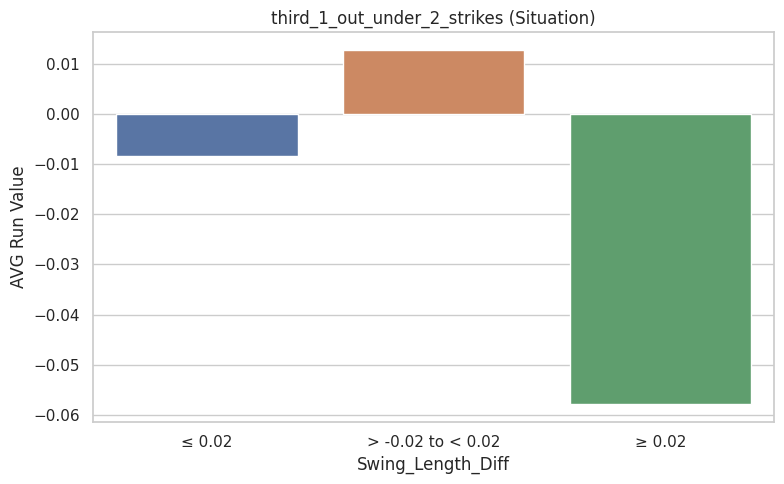


                   Swings
≤ 0.02               1366
> -0.02 to < 0.02     991
≥ 0.02                253



/tmp/ipython-input-11-3989766138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame.loc[:, 'group'] = pd.cut(data_frame[stat], bins=bins, labels=labels)


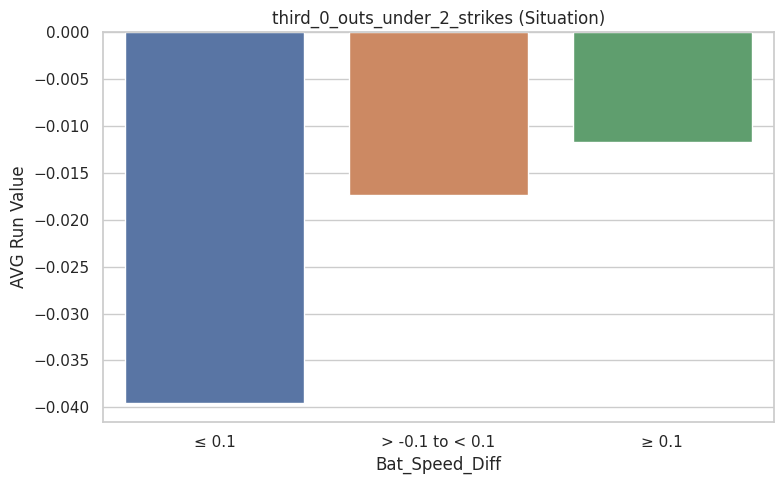


                 Swings
≤ 0.1               305
> -0.1 to < 0.1      48
≥ 0.1               243



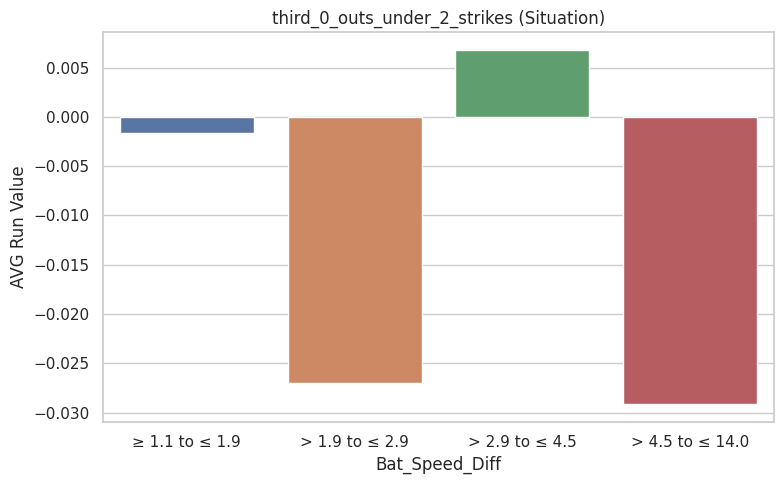


                 Swings
≥ 1.1 to ≤ 1.9       59
> 1.9 to ≤ 2.9       62
> 2.9 to ≤ 4.5       59
> 4.5 to ≤ 14.0      61



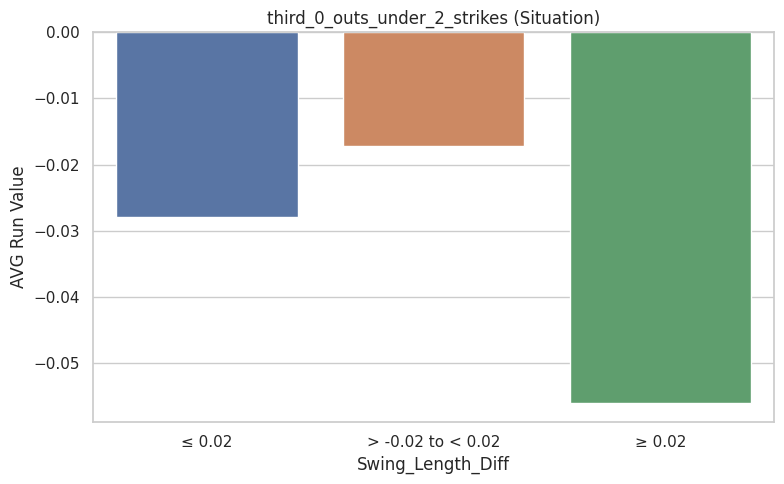


                   Swings
≤ 0.02                325
> -0.02 to < 0.02     219
≥ 0.02                 51



In [26]:
speeds = []
lenghts = []
for i in range(len(list1)):
  title = titles[i]
  speeds, lenghts = graph_run_exp(list1[i], 'Bat_Speed_Diff', speeds, lenghts, title)
  speeds, lenghts = graph_run_exp(list1[i], 'Swing_Length_Diff', speeds, lenghts, title)

In [27]:
under_two_strikes_summary = pd.DataFrame({'Bat Speed (compared to usual)': speeds, 'Swing Length (compared to usual)': lenghts}, index=titles)
print('                             Approach with Best AVG Run Value:')
under_two_strikes_summary

                             Approach with Best AVG Run Value:


,Bat Speed (compared to usual),Swing Length (compared to usual)
first_second_2_outs_under_2_strikes,Faster,Same
first_second_1_out_under_2_strikes,Faster,Same
first_second_0_outs_under_2_strikes,Faster,Same
first_third_2_outs_under_2_strikes,Faster,Same
first_third_1_out_under_2_strikes,Faster,Same
first_third_0_outs_under_2_strikes,Faster,Same
bases_loaded_2_outs_under_2_strikes,Faster,Same
bases_loaded_1_out_under_2_strikes,Faster,Same
bases_loaded_0_outs_under_2_strikes,Faster,Shorter
second_2_outs_under_2_strikes,Faster,Same
